In [1]:
# Packages have to go in this order... I don't know why

import numpy as np
import pandas as pd
import xarray as xr
import eofs
from eofs.standard import Eof
import glob



#you need intake-esm V 2020.11.4 and intake V 0.6.0

# import tensorflow as tf

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing


import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm

import copy
import fsspec
import pop_tools

import intake
import tensorflow as tf

## Functions

In [20]:
def plot_global_corr(field,lons,lats,title):
    plot_field= field.squeeze()
    lon =lons
    lat= lats

    plt.figure(figsize=(25, 20))
    proj = ccrs.PlateCarree(central_longitude=180)
    ax1 = plt.subplot(1, 1, 1, projection=proj)
    ax1.coastlines('50m')
    clevsRWS=np.arange(-1,1.05,.05) 
    haa = cm.get_cmap("Greys",len(clevsRWS))
    haa = haa(np.linspace(0,1,len(clevsRWS)))
    white=[1,1,1,1]
    haa[:3,:] = white
    #either do this 
    cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
    #or set an ocean nanmask! 
    nanmask = np.zeros_like(plot_field)+1
    plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)
    plt.plot([0-180,360-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.tick_params(labelsize=30) 
    ax1.set_extent([0,359,-85,85], crs=ccrs.PlateCarree())
    # ax1.add_feature(states_provinces, edgecolor='black')
    ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
    plt.title(title,fontsize=30)
    plt.colorbar(shrink=0.45)
    plt.show()
    
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

## Locate CESM lens PSL file

In [3]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PSL/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))

In [4]:
files

['/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PSL/b.e11.B1850C5CN.f09_g16.005.cam.h1.PSL.04020101-04991231.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PSL/b.e11.B1850C5CN.f09_g16.005.cam.h1.PSL.05000101-05991231.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PSL/b.e11.B1850C5CN.f09_g16.005.cam.h1.PSL.06000101-06991231.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PSL/b.e11.B1850C5CN.f09_g16.005.cam.h1.PSL.07000101-07991231.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PSL/b.e11.B1850C5CN.f09_g16.005.cam.h1.PSL.08000101-08991231.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PSL/b.e11.B1850C5CN.f09_g16.005.cam.h1.PSL.09000101-09991231.nc',
 '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PSL/b.e11.B1850C5CN.f09_g16.00

## Open in Xarray

In [7]:
DS = xr.open_mfdataset(files[0:3],combine='by_coords')
DS

<xarray.Dataset>
Dimensions:       (ilev: 31, lat: 192, lev: 30, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 108769)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * slat          (slat) float64 -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time          (time) object 0402-01-02 00:00:00 ... 0700-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    PSL           (time, lat, lon) float32 dask.array<chunksize=(35769, 192, 288), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(35769,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(35769,), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(35769,), meta=np.ndarray>
    date_written  (time) |S8 dask.array<chunksize=(35769,), meta=np.ndarray>
    datesec       (time) int32 dask.array<chunksize=(35769,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(35769,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(35769,), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(35769, 192), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(35769, 31), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(35769, 30), meta=np.ndarray>
    hybi          (time, ilev) float64 dask.array<chunksize=(35769, 31), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(35769, 30), meta=np.ndarray>
    mdt           (time) int32 1800 1800 1800 1800 1800 ... 1800 1800 1800 1800
    n2ovmr        (time) float64 dask.array<chunksize=(35769,), meta=np.ndarray>
    nbdate        (time) int32 2860101 2860101 2860101 ... 2860101 2860101
    nbsec         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ndbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ndcur         (time) int32 dask.array<chunksize=(35769,), meta=np.ndarray>
    nlon          (time, lat) int32 dask.array<chunksize=(35769, 192), meta=np.ndarray>
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(35769,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(35769,), meta=np.ndarray>
    ntrk          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ntrm          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ntrn          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    sol_tsi       (time) float64 dask.array<chunksize=(35769,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(35769, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(35769,), meta=np.ndarray>
    w_stag        (time, slat) float64 dask.array<chunksize=(35769, 191), meta=np.ndarray>
    wnummax       (time, lat) int32 dask.array<chunksize=(35769, 192), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b.e11.B1850C5CN.f09_g16.005
    title:                     UNSET
    logname:                   mai
    host:                      ys2738
    Version:                   $Name$
    revision_Id:               $Id$
    initial_file:              /glade/p/cesm/cseg//inputdata/atm/cam/inic/fv/...
    topography_file:           /glade/p/cesm/cseg//inputdata/atm/cam/topo/USG...
    history:                   Thu Oct 10 02:49:29 2013: /glade/apps/opt/nco/...
    NCO:                       4.3.4
 

## Remove the Monthly Mean

In [8]:
%%time
monthly = DS.groupby('time.month').mean(dim='time') #remove the monthly average
DS_daily_anom = DS.groupby('time.month') - monthly

/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing wit

In [33]:
%%time
#PNA
ds_HIST = DS_daily_anom.sel(lat=slice(20,85),lon=slice(120,300))
months =  [12,1,2] # for example
season1  =  ds_HIST.sel(time = np.in1d( ds_HIST['time.month'], months))
PSL = np.array(season1.PSL.data[:,:,:])
lats = season1['lat'].data
lons = season1['lon'].data

CPU times: user 1min 10s, sys: 11.7 s, total: 1min 22s
Wall time: 1min 13s


In [34]:
%%time
#I can probably do this much faster if I do the calc without this toolbox... 

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(PSL, weights=wgts)

CPU times: user 15min 13s, sys: 13.5 s, total: 15min 26s
Wall time: 3min 59s


In [35]:
%%time
# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input SLP anomalies at each grid point.
eof = solver.eofsAsCorrelation(neofs=2)
pcs = solver.pcs(npcs = 2,)

CPU times: user 1.41 s, sys: 715 ms, total: 2.13 s
Wall time: 1.81 s


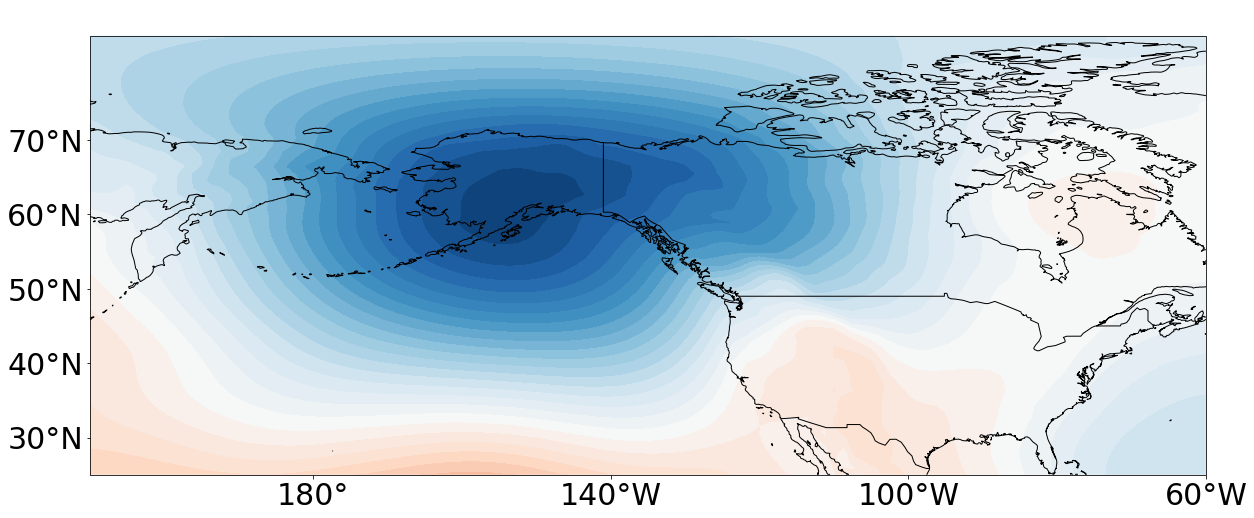

In [42]:
plot_field= eof[0,:,:].squeeze()
lon =lons
lat= lats

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsRWS=np.arange(-1,1,.05) 

haa = cm.get_cmap("Greys",len(clevsRWS))
haa = haa(np.linspace(0,1,len(clevsRWS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([150,300,25,84], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)

# plt.savefig('/Volumes/HotSlop/Figures_for_SP/Figures/RWS.png', dpi=300,bbox_inches='tight')
plt.show()

In [46]:
np.sum(solver.varianceFraction(neigs=10))

0.760209695209297

In [ ]:
'/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PSL/'

## Try on Monthly

In [83]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/Z3/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))

In [90]:
DS = xr.open_mfdataset(files[2:4],combine='by_coords')
DS

<xarray.Dataset>
Dimensions:       (ilev: 31, lat: 192, lev: 30, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 2400)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * slat          (slat) float64 -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time          (time) object 0600-02-01 00:00:00 ... 0800-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    Z3            (time, lev, lat, lon) float32 dask.array<chunksize=(1200, 30, 192, 288), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    date_written  (time) |S8 dask.array<chunksize=(1200,), meta=np.ndarray>
    datesec       (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(1200, 192), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(1200, 31), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(1200, 30), meta=np.ndarray>
    hybi          (time, ilev) float64 dask.array<chunksize=(1200, 31), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(1200, 30), meta=np.ndarray>
    mdt           (time) int32 1800 1800 1800 1800 1800 ... 1800 1800 1800 1800
    n2ovmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    nbdate        (time) int32 2860101 2860101 2860101 ... 2860101 2860101
    nbsec         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ndbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ndcur         (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    nlon          (time, lat) int32 dask.array<chunksize=(1200, 192), meta=np.ndarray>
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    ntrk          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ntrm          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ntrn          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    sol_tsi       (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(1200,), meta=np.ndarray>
    w_stag        (time, slat) float64 dask.array<chunksize=(1200, 191), meta=np.ndarray>
    wnummax       (time, lat) int32 dask.array<chunksize=(1200, 192), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b.e11.B1850C5CN.f09_g16.005
    title:                     UNSET
    logname:                   mai
    host:                      ys0736
    Version:                   $Name$
    revision_Id:               $Id$
    initial_file:              /glade/p/cesm/cseg//inputdata/atm/cam/inic/fv/...
    topography_file:           /glade/p/cesm/cseg//inputdata/atm/cam/topo/USG...
    history:                   Sun Oct  6 04:40:40 2013: /glade/apps/opt/nco/...
    NCO:                       4.3.4
    nco_openmp_th

## Remove Monthly Mean

In [104]:
%%time
# monthly = DS.groupby('time.month').mean(dim='time') #remove the monthly average
# DS_monthly_anom = DS.groupby('time.month') - monthly

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [106]:
%%time
#PNA
ds_HIST = DS.sel(lat=slice(20,85),lon=slice(120,300))
months =  [12,1,2] # for example
season1  =  ds_HIST.sel(time = np.in1d( ds_HIST['time.month'], months))
PSL = np.array(season1.Z3.data[:,18,:,:])
PSL = PSL - np.mean(PSL,axis=0)
lats = season1['lat'].data
lons = season1['lon'].data

CPU times: user 53.5 s, sys: 4.63 s, total: 58.1 s
Wall time: 58.1 s


In [107]:
ds_HIST

<xarray.Dataset>
Dimensions:       (ilev: 31, lat: 69, lev: 30, lon: 145, nbnd: 2, slat: 191, slon: 288, time: 2400)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat           (lat) float64 20.26 21.2 22.15 23.09 ... 82.46 83.4 84.35
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * slat          (slat) float64 -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * lon           (lon) float64 120.0 121.2 122.5 123.8 ... 297.5 298.8 300.0
  * time          (time) object 0600-02-01 00:00:00 ... 0800-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    Z3            (time, lev, lat, lon) float32 dask.array<chunksize=(1200, 30, 69, 145), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    date_written  (time) |S8 dask.array<chunksize=(1200,), meta=np.ndarray>
    datesec       (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(1200, 69), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(1200, 31), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(1200, 30), meta=np.ndarray>
    hybi          (time, ilev) float64 dask.array<chunksize=(1200, 31), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(1200, 30), meta=np.ndarray>
    mdt           (time) int32 1800 1800 1800 1800 1800 ... 1800 1800 1800 1800
    n2ovmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    nbdate        (time) int32 2860101 2860101 2860101 ... 2860101 2860101
    nbsec         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ndbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ndcur         (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    nlon          (time, lat) int32 dask.array<chunksize=(1200, 69), meta=np.ndarray>
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    ntrk          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ntrm          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ntrn          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    sol_tsi       (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(1200,), meta=np.ndarray>
    w_stag        (time, slat) float64 dask.array<chunksize=(1200, 191), meta=np.ndarray>
    wnummax       (time, lat) int32 dask.array<chunksize=(1200, 69), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b.e11.B1850C5CN.f09_g16.005
    title:                     UNSET
    logname:                   mai
    host:                      ys0736
    Version:                   $Name$
    revision_Id:               $Id$
    initial_file:              /glade/p/cesm/cseg//inputdata/atm/cam/inic/fv/...
    topography_file:           /glade/p/cesm/cseg//inputdata/atm/cam/topo/USG...
    history:                   Sun Oct  6 04:40:40 2013: /glade/apps/opt/nco/...
    NCO:                       4.3.4
    nco_openmp_thread_numb

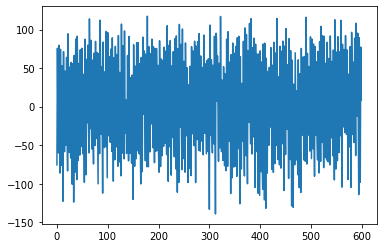

In [112]:
plt.plot(PSL[:,10,10])

In [108]:
%%time
#I can probably do this much faster if I do the calc without this toolbox... 

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(PSL, weights=wgts)

CPU times: user 3.01 s, sys: 594 ms, total: 3.6 s
Wall time: 988 ms


In [109]:
%%time
# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input SLP anomalies at each grid point.
eof = solver.eofsAsCorrelation(neofs=3)
pcs = solver.pcs(npcs = 2,)

CPU times: user 43 ms, sys: 25.1 ms, total: 68.1 ms
Wall time: 52.1 ms


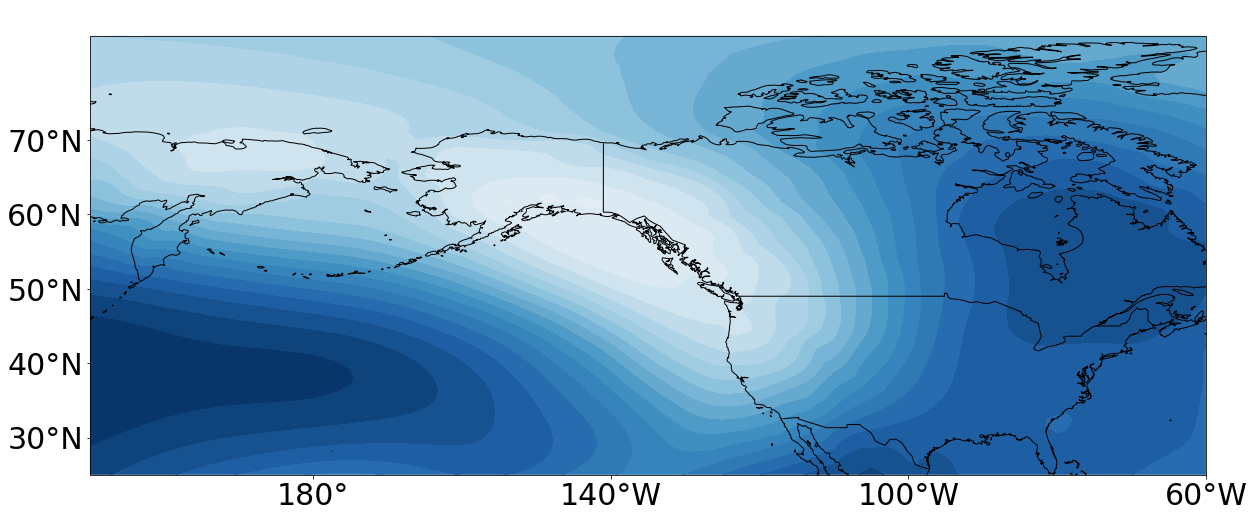

In [118]:
plot_field= eof[0,:,:].squeeze()
lon =lons
lat= lats

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsRWS=np.arange(-1,1,.05) 

haa = cm.get_cmap("Greys",len(clevsRWS))
haa = haa(np.linspace(0,1,len(clevsRWS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([150,300,25,84], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)

# plt.savefig('/Volumes/HotSlop/Figures_for_SP/Figures/RWS.png', dpi=300,bbox_inches='tight')
plt.show()

In [115]:
solver.varianceFraction(neigs=10)

array([0.52678906, 0.11103975, 0.09350799, 0.04892129, 0.04156577,
       0.02782461, 0.02358717, 0.02154992, 0.01642238, 0.01047768])

In [121]:
ds_HIST = DS.sel(lat=slice(20,85),lon=slice(120,300))
months =  [12,1,2] # for example
season1  =  ds_HIST.sel(time = np.in1d( ds_HIST['time.month'], months))
PSL = np.array(season1.Z3.data[:,18,:,:])

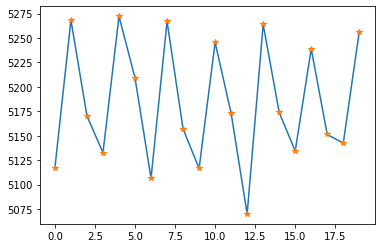

In [126]:
plt.plot(PSL[:20,10,10])
plt.plot(PSL[:20,10,10],'*')

In [127]:
%%time
monthly = DS.groupby('time.month').mean(dim='time') #remove the monthly average
DS_monthly_anom = DS.groupby('time.month') - monthly

CPU times: user 888 ms, sys: 12 ms, total: 900 ms
Wall time: 896 ms


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing wit

In [137]:
dd = DS_monthly_anom.sel(lat=slice(20,85),lon=slice(120,300))
months =  [12,1,2] # for example
season1  = dd.sel(time = np.in1d( ds_HIST['time.month'], months))

In [138]:
z500=np.array(season1.Z3.data[:,18,:,:])

In [139]:
z500.shape

(600, 69, 145)

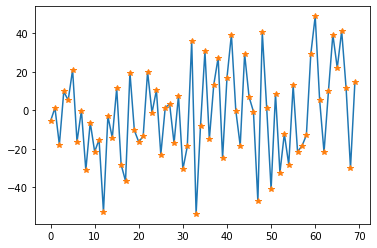

In [140]:
plt.plot(z500[:70,10,10])
plt.plot(z500[:70,10,10],'*')

In [144]:
lats = season1['lat'].data
lons = season1['lon'].data
#I can probably do this much faster if I do the calc without this toolbox... 

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(z500, weights=wgts)

In [145]:
# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input SLP anomalies at each grid point.
eof = solver.eofsAsCorrelation(neofs=3)
pcs = solver.pcs(npcs = 2,)

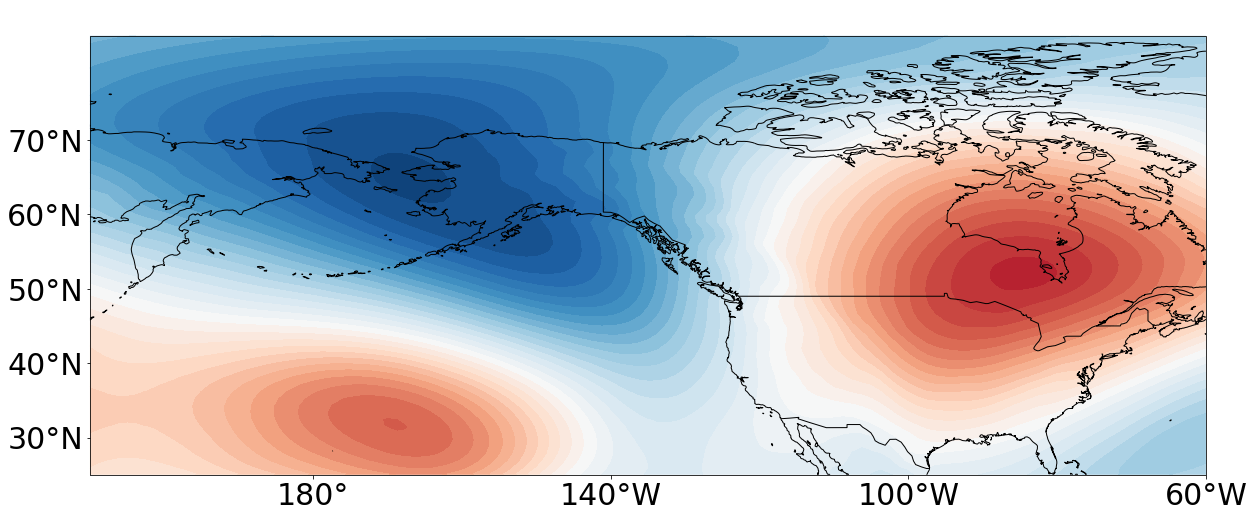

In [147]:
plot_field= eof[1,:,:].squeeze()
lon =lons
lat= lats

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsRWS=np.arange(-1,1,.05) 

haa = cm.get_cmap("Greys",len(clevsRWS))
haa = haa(np.linspace(0,1,len(clevsRWS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([150,300,25,84], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)

# plt.savefig('/Volumes/HotSlop/Figures_for_SP/Figures/RWS.png', dpi=300,bbox_inches='tight')
plt.show()

In [148]:
solver.varianceFraction(neigs=10)

array([0.2269728 , 0.20349724, 0.09819505, 0.0860869 , 0.06312464,
       0.04734051, 0.04462504, 0.03319315, 0.02407299, 0.0194737 ])

## PSL

In [149]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PSL/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))

In [183]:
DS = xr.open_mfdataset(files[2:4],combine='by_coords')
DS

<xarray.Dataset>
Dimensions:       (ilev: 31, lat: 192, lev: 30, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 2400)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * slat          (slat) float64 -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time          (time) object 0600-02-01 00:00:00 ... 0800-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    PSL           (time, lat, lon) float32 dask.array<chunksize=(1200, 192, 288), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    date_written  (time) |S8 dask.array<chunksize=(1200,), meta=np.ndarray>
    datesec       (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(1200, 192), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(1200, 31), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(1200, 30), meta=np.ndarray>
    hybi          (time, ilev) float64 dask.array<chunksize=(1200, 31), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(1200, 30), meta=np.ndarray>
    mdt           (time) int32 1800 1800 1800 1800 1800 ... 1800 1800 1800 1800
    n2ovmr        (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    nbdate        (time) int32 2860101 2860101 2860101 ... 2860101 2860101
    nbsec         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ndbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ndcur         (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    nlon          (time, lat) int32 dask.array<chunksize=(1200, 192), meta=np.ndarray>
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nscur         (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1200,), meta=np.ndarray>
    ntrk          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ntrm          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    ntrn          (time) int32 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    sol_tsi       (time) float64 dask.array<chunksize=(1200,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(1200,), meta=np.ndarray>
    w_stag        (time, slat) float64 dask.array<chunksize=(1200, 191), meta=np.ndarray>
    wnummax       (time, lat) int32 dask.array<chunksize=(1200, 192), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b.e11.B1850C5CN.f09_g16.005
    title:                     UNSET
    logname:                   mai
    host:                      ys0736
    Version:                   $Name$
    revision_Id:               $Id$
    initial_file:              /glade/p/cesm/cseg//inputdata/atm/cam/inic/fv/...
    topography_file:           /glade/p/cesm/cseg//inputdata/atm/cam/topo/USG...
    history:                   Sun Oct  6 03:09:17 2013: /glade/apps/opt/nco/...
    NCO:                       4.3.4
    nco_openmp_thread_numb

In [151]:
%%time
monthly = DS.groupby('time.month').mean(dim='time') #remove the monthly average
DS_monthly_anom = DS.groupby('time.month') - monthly

CPU times: user 892 ms, sys: 17.1 ms, total: 909 ms
Wall time: 900 ms


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing wit

In [238]:

DS = xr.open_mfdataset(files[2:4],combine='by_coords')
monthly = DS.groupby('time.month').mean(dim='time') #remove the monthly average
DS_monthly_anom = DS.groupby('time.month') - monthly


dd = DS_monthly_anom.sel(lat=slice(20,85),lon=slice(120,300))
months =  [12] # for example
season1  = dd.sel(time = np.in1d(dd['time.month'], months))

/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing wit

In [239]:
season1.time

<xarray.DataArray 'time' (time: 200)>
array([cftime.DatetimeNoLeap(600, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(601, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(602, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(603, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(604, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(605, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(606, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(607, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(608, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(609, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(610, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(611, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(612, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(613, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(614, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(615, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(616, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(617, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(618, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(619, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(620, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(621, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(622, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(623, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(624, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(625, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(626, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(627, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(628, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(629, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(630, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(631, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(632, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(633, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(634, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(635, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(636, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(637, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(638, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(639, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(640, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(641, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(642, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(643, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(644, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(645, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(646, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(647, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(648, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(649, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(650, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(651, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(652, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(653, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(654, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(655, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(656, 12, 1, 0, 0, 0, 0, 3, 335),
       cftime.DatetimeNoLeap(657, 12, 1, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeNoLeap(658, 12, 1, 0, 0, 0, 0, 5, 335),
       cftime.DatetimeNoLeap(659, 12, 1, 0, 0, 0, 0, 6, 335),
       cftime.DatetimeNoLeap(660, 12, 1, 0, 0, 0, 0, 0, 335),
       cftime.DatetimeNoLeap(661, 12, 1, 0, 0, 0, 0, 1, 335),
       cftime.DatetimeNoLeap(662, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(663, 12, 1, 0, 0, 0, 0, 3, 

In [240]:
PSL=np.array(season1.PSL.data[:,:,:])

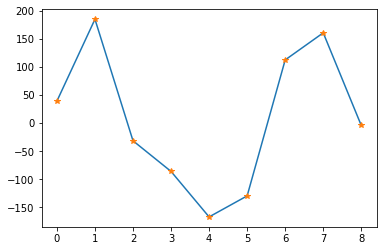

In [241]:
plt.plot(PSL[:9,10,10])
plt.plot(PSL[:9,10,10],'*')

In [242]:
lats = season1['lat'].data
lons = season1['lon'].data
#I can probably do this much faster if I do the calc without this toolbox... 

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(PSL,wgts)

In [248]:
# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input SLP anomalies at each grid point.
eof = solver.eofsAsCorrelation(neofs=3)
pcs = solver.pcs(npcs = 3,)

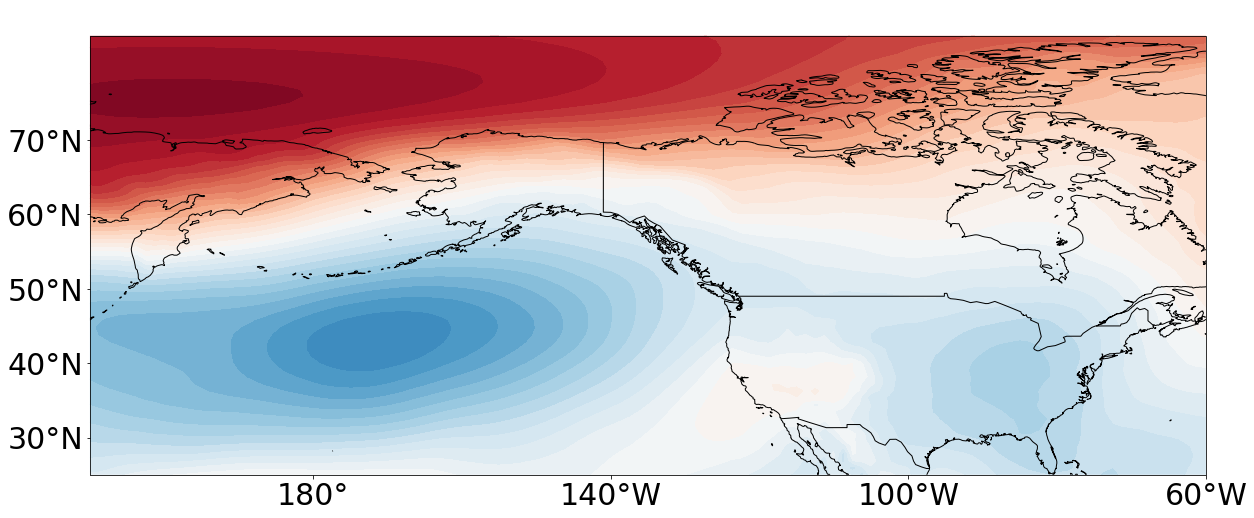

In [249]:
plot_field= eof[1,:,:].squeeze()
lon =lons
lat= lats

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsRWS=np.arange(-1,1.05,.05) 

haa = cm.get_cmap("Greys",len(clevsRWS))
haa = haa(np.linspace(0,1,len(clevsRWS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([150,300,25,84], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)

# plt.savefig('/Volumes/HotSlop/Figures_for_SP/Figures/RWS.png', dpi=300,bbox_inches='tight')
plt.show()

## try it fucking old school.... 

In [386]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/Z3/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))

In [387]:
%%time
DS = xr.open_mfdataset(files[2:6],combine='by_coords')
DS
months =  [1] # for example
season1  = DS.sel(time = np.in1d(DS['time.month'], months))
season1=season1.sel(lat=slice(20,75),lon=slice(120,300))
lats = season1['lat'].data
lons = season1['lon'].data

CPU times: user 151 ms, sys: 6.97 ms, total: 158 ms
Wall time: 157 ms


In [388]:
%%time
PSL = np.array(season1['Z3'].data[:,18,:,:])
PSL = PSL-np.mean(PSL,axis=0)

CPU times: user 1min 46s, sys: 9.5 s, total: 1min 56s
Wall time: 2min 4s


In [389]:
%%time
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
wgts = np.expand_dims(wgts,axis=0)
##
psl=PSL*wgts

CPU times: user 5.6 ms, sys: 4.99 ms, total: 10.6 ms
Wall time: 9.78 ms


In [390]:
%%time
Mask=np.ones([psl.shape[1],psl.shape[2]])

psl_flat = np.reshape(psl,[psl.shape[0],-1])
#get nan locations: 
nan_flat = np.where(np.isnan(psl_flat[0,:]))[0]
notnan_flat = np.where(~np.isnan(psl_flat[0,:]))[0]
#get 0 locations
zero_flat = np.where(psl_flat[0,:]==0)[0]
#get value locations 
notzero_flat = np.where(np.ndarray.flatten(Mask)==1)[0]

print('...forming smaller matrix...')
eof_psl = np.zeros([psl_flat.shape[0],notzero_flat.shape[0]])

for ii in range(eof_psl.shape[0]):
    eof_psl[ii,:]=psl_flat[ii,notzero_flat]
    
print('...done preprocessing...')


...forming smaller matrix...
...done preprocessing...
CPU times: user 933 µs, sys: 14 ms, total: 14.9 ms
Wall time: 14.2 ms


...starting svd...
...done svd...


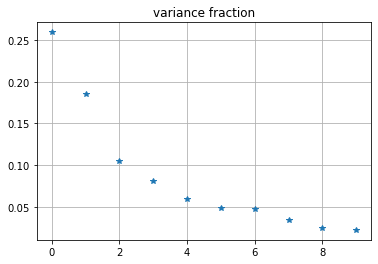

CPU times: user 743 ms, sys: 283 ms, total: 1.03 s
Wall time: 286 ms


In [391]:
%%time
dFIN = eof_psl #hopefully this is a time x space anomaly matrix... where time is shorter than space. 
print('...starting svd...')
A, Lh, E = np.linalg.svd(dFIN.T,full_matrices=False)
# Singular values are the square-root of the eigenvalues of the
# covariance matrix. Construct the eigenvalues appropriately and
# normalize by N-ddof where N is the number of observations. This
# corresponds to the eigenvalues of the normalized covariance matrix.
print('...done svd...')
ddof = 1 #degrees of freedom. 
records = dFIN.shape[0]
normfactor = float(records-ddof)
L = Lh*Lh / normfactor  #singular values
# Store the number of eigenvalues (and hence EOFs) that were actually computed.
neofs = len(L)

P = E.T*Lh
P = P/np.sqrt(L) #scaled to unit variance (e.g., divided by the square-root of their eigenvalue).
A = A.T
#variance fraction 
varfrac = L/L.sum()
total_anomaly_variance = L.sum()
#variance fraction 
plt.plot(varfrac[:10],'*')
plt.grid(True)
plt.title('variance fraction')
plt.show()

...Done...
Fraction of Nino years: 0.1575
Fraction of Nina years: 0.1625
Fraction of Neurtral years: 0.68
sum: 1.0


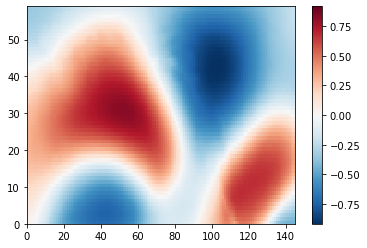

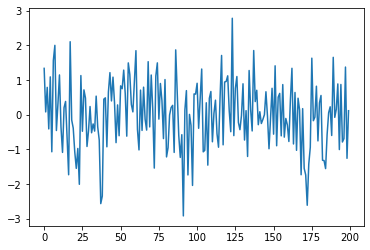

CPU times: user 973 ms, sys: 18 ms, total: 991 ms
Wall time: 983 ms


In [394]:
%%time
#grab the eof you want. 
eof_number = 0
Pcs = P[:,eof_number]
eofs = A[eof_number,:]/ np.sqrt(L[eof_number]) 

##reform pattern. 
mapss = np.zeros([PSL.shape[1],PSL.shape[2]]) 
for lala in range(PSL.shape[1]):
    for lolo in range(PSL.shape[2]):
        mapss[lala,lolo]=np.corrcoef(Pcs,PSL[:,lala,lolo])[0,1]
        


#make sure pattern is positive oriented. 
if np.sum(eofs)<0:
    eofs = -1*eofs
    Pcs = -1*Pcs


print('...Done...')
print('Fraction of Nino years:',np.sum(Pcs>=1)/len(Pcs))
print('Fraction of Nina years:',np.sum(Pcs<=-1)/len(Pcs))
print('Fraction of Neurtral years:',np.sum((Pcs>=-1) &(Pcs<=1))/len(Pcs))
print('sum:',np.sum(Pcs>=1)/len(Pcs) + np.sum(Pcs<=-1)/len(Pcs) + np.sum((Pcs>=-1) &(Pcs<=1))/len(Pcs))

plt.pcolor(mapss,cmap='RdBu_r',vmin=-np.max(np.abs(mapss)),vmax=np.max(np.abs(mapss)))
plt.colorbar()
plt.show()
plt.plot(Pcs[0:200])
plt.show()


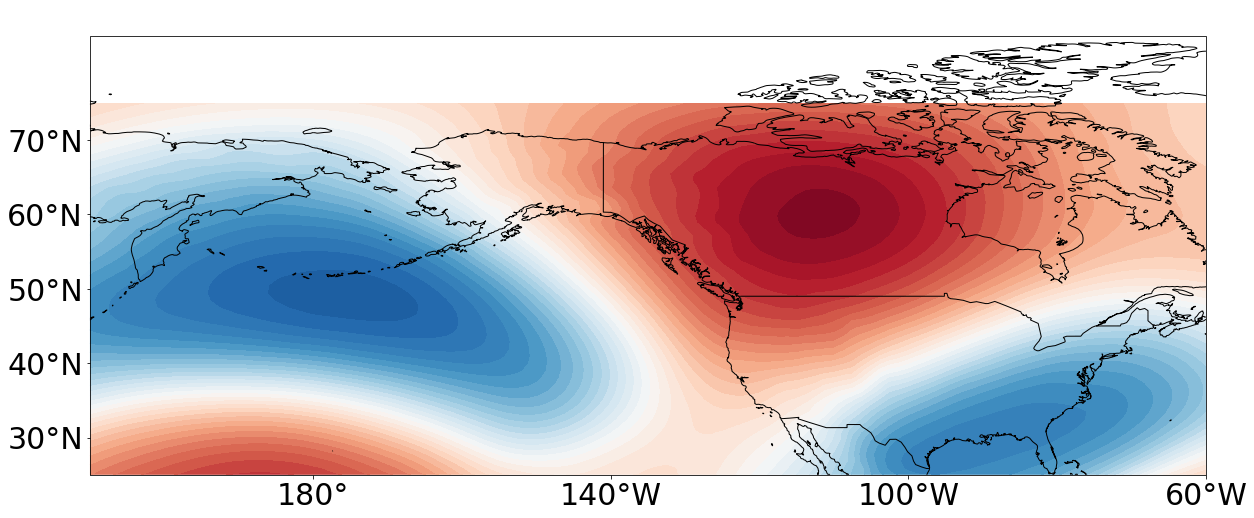

In [395]:
plot_field= mapss.squeeze()
lon =lons
lat= lats

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsRWS=np.arange(-1,1.05,.05) 

haa = cm.get_cmap("Greys",len(clevsRWS))
haa = haa(np.linspace(0,1,len(clevsRWS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1

plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([150,300,25,84], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)

# plt.savefig('/Volumes/HotSlop/Figures_for_SP/Figures/RWS.png', dpi=300,bbox_inches='tight')
plt.show()

In [467]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/Z500/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))

In [468]:
%%time
DS = xr.open_mfdataset(files[6:8],combine='by_coords')
DS
months =  [1] # for example
season1  = DS.sel(time = np.in1d(DS['time.month'], months))
season1=season1.sel(lat=slice(20,75),lon=slice(120,300))
lats = season1['lat'].data
lons = season1['lon'].data

CPU times: user 856 ms, sys: 171 ms, total: 1.03 s
Wall time: 1.88 s


In [469]:
%%time
PSL = np.array(season1['Z500'].data[:,:,:])
PSL = PSL-np.mean(PSL,axis=0)

CPU times: user 42 s, sys: 5.35 s, total: 47.4 s
Wall time: 47.4 s


In [470]:
%%time
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
wgts = np.expand_dims(wgts,axis=0)
##
psl=PSL*wgts

CPU times: user 76.6 ms, sys: 75 ms, total: 152 ms
Wall time: 151 ms


In [471]:
%%time
Mask=np.ones([psl.shape[1],psl.shape[2]])

psl_flat = np.reshape(psl,[psl.shape[0],-1])
#get nan locations: 
nan_flat = np.where(np.isnan(psl_flat[0,:]))[0]
notnan_flat = np.where(~np.isnan(psl_flat[0,:]))[0]
#get 0 locations
zero_flat = np.where(psl_flat[0,:]==0)[0]
#get value locations 
notzero_flat = np.where(np.ndarray.flatten(Mask)==1)[0]

print('...forming smaller matrix...')
eof_psl = np.zeros([psl_flat.shape[0],notzero_flat.shape[0]])

for ii in range(eof_psl.shape[0]):
    eof_psl[ii,:]=psl_flat[ii,notzero_flat]
    
print('...done preprocessing...')

...forming smaller matrix...
...done preprocessing...
CPU times: user 145 ms, sys: 55 ms, total: 200 ms
Wall time: 199 ms


...starting svd...
...done svd...


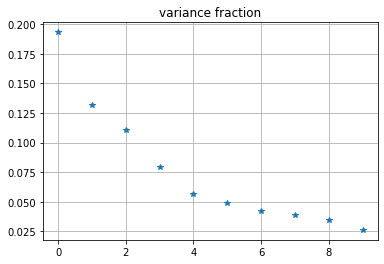

CPU times: user 4min 26s, sys: 6.38 s, total: 4min 33s
Wall time: 1min 9s


In [472]:
%%time
dFIN = eof_psl #hopefully this is a time x space anomaly matrix... where time is shorter than space. 
print('...starting svd...')
A, Lh, E = np.linalg.svd(dFIN.T,full_matrices=False)
# Singular values are the square-root of the eigenvalues of the
# covariance matrix. Construct the eigenvalues appropriately and
# normalize by N-ddof where N is the number of observations. This
# corresponds to the eigenvalues of the normalized covariance matrix.
print('...done svd...')
ddof = 1 #degrees of freedom. 
records = dFIN.shape[0]
normfactor = float(records-ddof)
L = Lh*Lh / normfactor  #singular values
# Store the number of eigenvalues (and hence EOFs) that were actually computed.
neofs = len(L)

P = E.T*Lh
P = P/np.sqrt(L) #scaled to unit variance (e.g., divided by the square-root of their eigenvalue).
A = A.T
#variance fraction 
varfrac = L/L.sum()
total_anomaly_variance = L.sum()
#variance fraction 
plt.plot(varfrac[:10],'*')
plt.grid(True)
plt.title('variance fraction')
plt.show()

...Done...
Fraction of Nino years: 0.15774193548387097
Fraction of Nina years: 0.16580645161290322
Fraction of Neurtral years: 0.6764516129032258
sum: 1.0


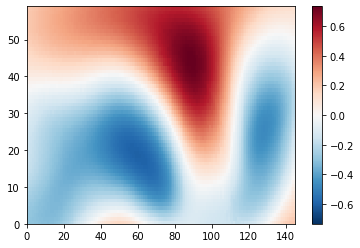

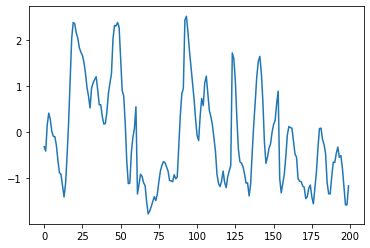

CPU times: user 1.42 s, sys: 13.1 ms, total: 1.44 s
Wall time: 1.43 s


In [476]:
%%time
#grab the eof you want. 
eof_number = 1
Pcs = P[:,eof_number]
eofs = A[eof_number,:]/ np.sqrt(L[eof_number]) 

##reform pattern. 
mapss = np.zeros([PSL.shape[1],PSL.shape[2]]) 
for lala in range(PSL.shape[1]):
    for lolo in range(PSL.shape[2]):
        mapss[lala,lolo]=np.corrcoef(Pcs,PSL[:,lala,lolo])[0,1]
        


#make sure pattern is positive oriented. 
if np.sum(eofs)<0:
    eofs = -1*eofs
    Pcs = -1*Pcs


print('...Done...')
print('Fraction of Nino years:',np.sum(Pcs>=1)/len(Pcs))
print('Fraction of Nina years:',np.sum(Pcs<=-1)/len(Pcs))
print('Fraction of Neurtral years:',np.sum((Pcs>=-1) &(Pcs<=1))/len(Pcs))
print('sum:',np.sum(Pcs>=1)/len(Pcs) + np.sum(Pcs<=-1)/len(Pcs) + np.sum((Pcs>=-1) &(Pcs<=1))/len(Pcs))

plt.pcolor(mapss,cmap='RdBu_r',vmin=-np.max(np.abs(mapss)),vmax=np.max(np.abs(mapss)))
plt.colorbar()
plt.show()
plt.plot(Pcs[0:200])
plt.show()


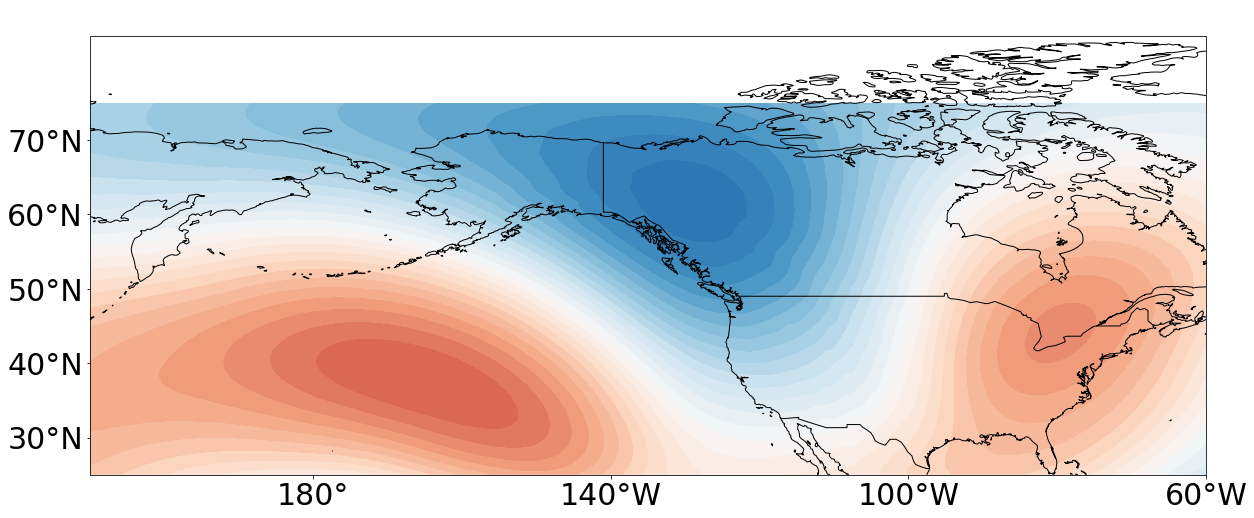

In [477]:
plot_field= mapss.squeeze()
lon =lons
lat= lats

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsRWS=np.arange(-1,1.05,.05) 

haa = cm.get_cmap("Greys",len(clevsRWS))
haa = haa(np.linspace(0,1,len(clevsRWS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1

plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([150,300,25,84], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)

# plt.savefig('/Volumes/HotSlop/Figures_for_SP/Figures/RWS.png', dpi=300,bbox_inches='tight')
plt.show()

In [410]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PSL/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))

In [412]:
%%time
DS = xr.open_mfdataset(files[2:6],combine='by_coords')
DS
months =  [1] # for example
season1  = DS.sel(time = np.in1d(DS['time.month'], months))
season1=season1.sel(lat=slice(20,75),lon=slice(120,300))
lats = season1['lat'].data
lons = season1['lon'].data

CPU times: user 158 ms, sys: 5.03 ms, total: 163 ms
Wall time: 268 ms


In [414]:
%%time
PSL = np.array(season1['PSL'].data[:,:,:])
PSL = PSL-np.mean(PSL,axis=0)

CPU times: user 2.81 s, sys: 333 ms, total: 3.14 s
Wall time: 3.39 s


In [415]:
%%time
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
wgts = np.expand_dims(wgts,axis=0)
##
psl=PSL*wgts

CPU times: user 7.32 ms, sys: 57 µs, total: 7.38 ms
Wall time: 6.46 ms


In [416]:
%%time
Mask=np.ones([psl.shape[1],psl.shape[2]])

psl_flat = np.reshape(psl,[psl.shape[0],-1])
#get nan locations: 
nan_flat = np.where(np.isnan(psl_flat[0,:]))[0]
notnan_flat = np.where(~np.isnan(psl_flat[0,:]))[0]
#get 0 locations
zero_flat = np.where(psl_flat[0,:]==0)[0]
#get value locations 
notzero_flat = np.where(np.ndarray.flatten(Mask)==1)[0]

print('...forming smaller matrix...')
eof_psl = np.zeros([psl_flat.shape[0],notzero_flat.shape[0]])

for ii in range(eof_psl.shape[0]):
    eof_psl[ii,:]=psl_flat[ii,notzero_flat]
    
print('...done preprocessing...')


...forming smaller matrix...
...done preprocessing...
CPU times: user 15 ms, sys: 1.95 ms, total: 16.9 ms
Wall time: 16 ms


...starting svd...
...done svd...


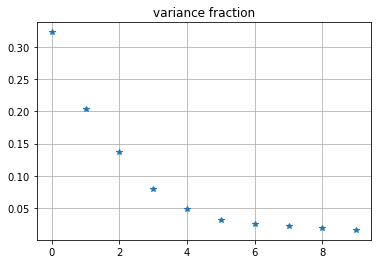

CPU times: user 754 ms, sys: 256 ms, total: 1.01 s
Wall time: 281 ms


In [417]:
%%time
dFIN = eof_psl #hopefully this is a time x space anomaly matrix... where time is shorter than space. 
print('...starting svd...')
A, Lh, E = np.linalg.svd(dFIN.T,full_matrices=False)
# Singular values are the square-root of the eigenvalues of the
# covariance matrix. Construct the eigenvalues appropriately and
# normalize by N-ddof where N is the number of observations. This
# corresponds to the eigenvalues of the normalized covariance matrix.
print('...done svd...')
ddof = 1 #degrees of freedom. 
records = dFIN.shape[0]
normfactor = float(records-ddof)
L = Lh*Lh / normfactor  #singular values
# Store the number of eigenvalues (and hence EOFs) that were actually computed.
neofs = len(L)

P = E.T*Lh
P = P/np.sqrt(L) #scaled to unit variance (e.g., divided by the square-root of their eigenvalue).
A = A.T
#variance fraction 
varfrac = L/L.sum()
total_anomaly_variance = L.sum()
#variance fraction 
plt.plot(varfrac[:10],'*')
plt.grid(True)
plt.title('variance fraction')
plt.show()

...Done...
Fraction of Nino years: 0.165
Fraction of Nina years: 0.1575
Fraction of Neurtral years: 0.6775
sum: 1.0


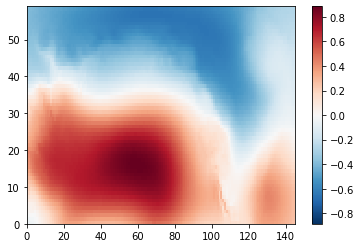

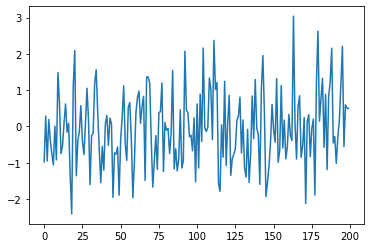

CPU times: user 995 ms, sys: 14.3 ms, total: 1.01 s
Wall time: 1 s


In [420]:
%%time
#grab the eof you want. 
eof_number = 1
Pcs = P[:,eof_number]
eofs = A[eof_number,:]/ np.sqrt(L[eof_number]) 

##reform pattern. 
mapss = np.zeros([PSL.shape[1],PSL.shape[2]]) 
for lala in range(PSL.shape[1]):
    for lolo in range(PSL.shape[2]):
        mapss[lala,lolo]=np.corrcoef(Pcs,PSL[:,lala,lolo])[0,1]
        


#make sure pattern is positive oriented. 
if np.sum(eofs)<0:
    eofs = -1*eofs
    Pcs = -1*Pcs


print('...Done...')
print('Fraction of Nino years:',np.sum(Pcs>=1)/len(Pcs))
print('Fraction of Nina years:',np.sum(Pcs<=-1)/len(Pcs))
print('Fraction of Neurtral years:',np.sum((Pcs>=-1) &(Pcs<=1))/len(Pcs))
print('sum:',np.sum(Pcs>=1)/len(Pcs) + np.sum(Pcs<=-1)/len(Pcs) + np.sum((Pcs>=-1) &(Pcs<=1))/len(Pcs))

plt.pcolor(mapss,cmap='RdBu_r',vmin=-np.max(np.abs(mapss)),vmax=np.max(np.abs(mapss)))
plt.colorbar()
plt.show()
plt.plot(Pcs[0:200])
plt.show()


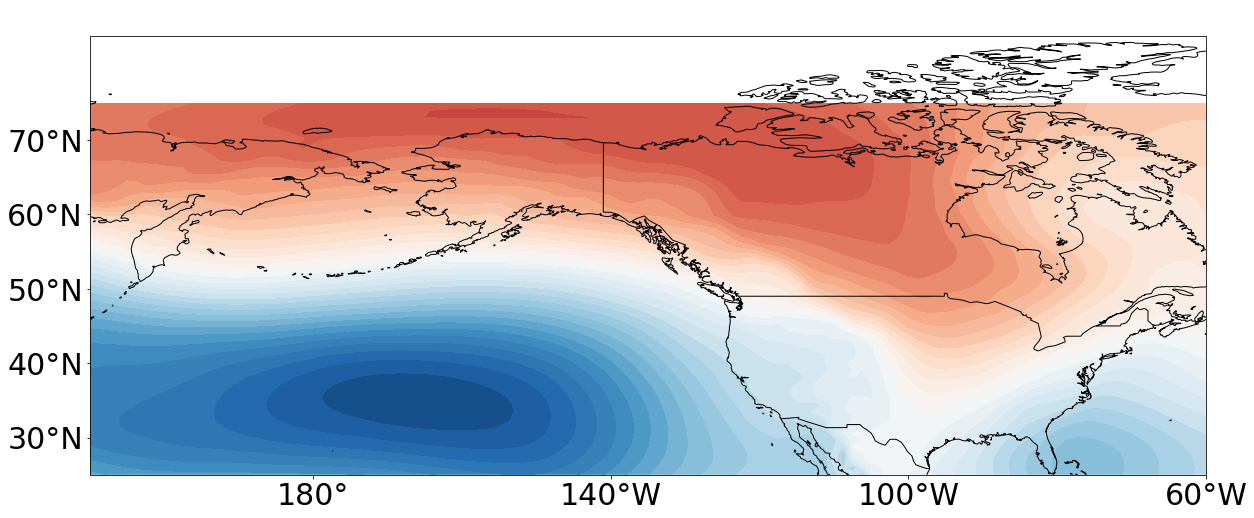

In [421]:
plot_field= mapss.squeeze()
lon =lons
lat= lats

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsRWS=np.arange(-1,1.05,.05) 

haa = cm.get_cmap("Greys",len(clevsRWS))
haa = haa(np.linspace(0,1,len(clevsRWS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1

plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([150,300,25,84], crs=ccrs.PlateCarree())
# ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)

# plt.savefig('/Volumes/HotSlop/Figures_for_SP/Figures/RWS.png', dpi=300,bbox_inches='tight')
plt.show()

## Eof Flow: 

1) Take Daily Files 

2) calc monthly from daily.

3) get monthly anoms. 

4) get eofs of monthly. 

5) project onto daily to get pseudo pcs. 

6) return patterns as correlation + pcs.

## PNA

doing:  [12, 1, 2]
...Decomposing Modes...
...loading daily...
sum eof PNA: 935.238110998214
flipping PNA [12, 1, 2]
sum eof NPO: -522.4536683666905
..loading global...
correlating


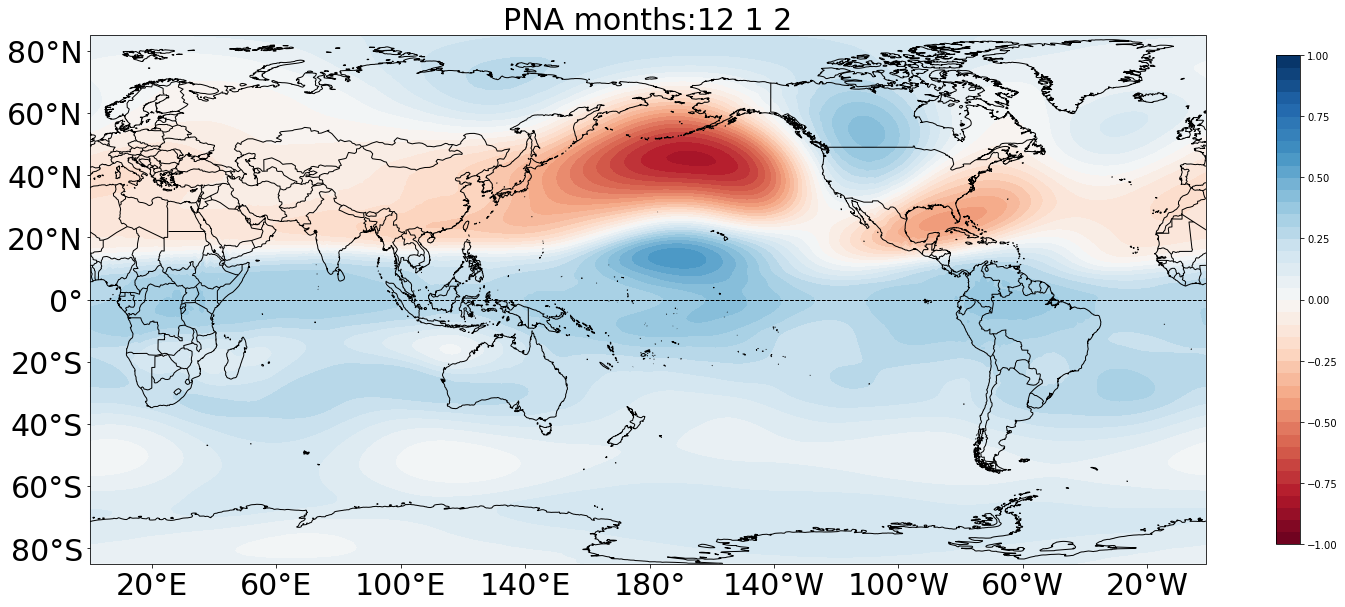

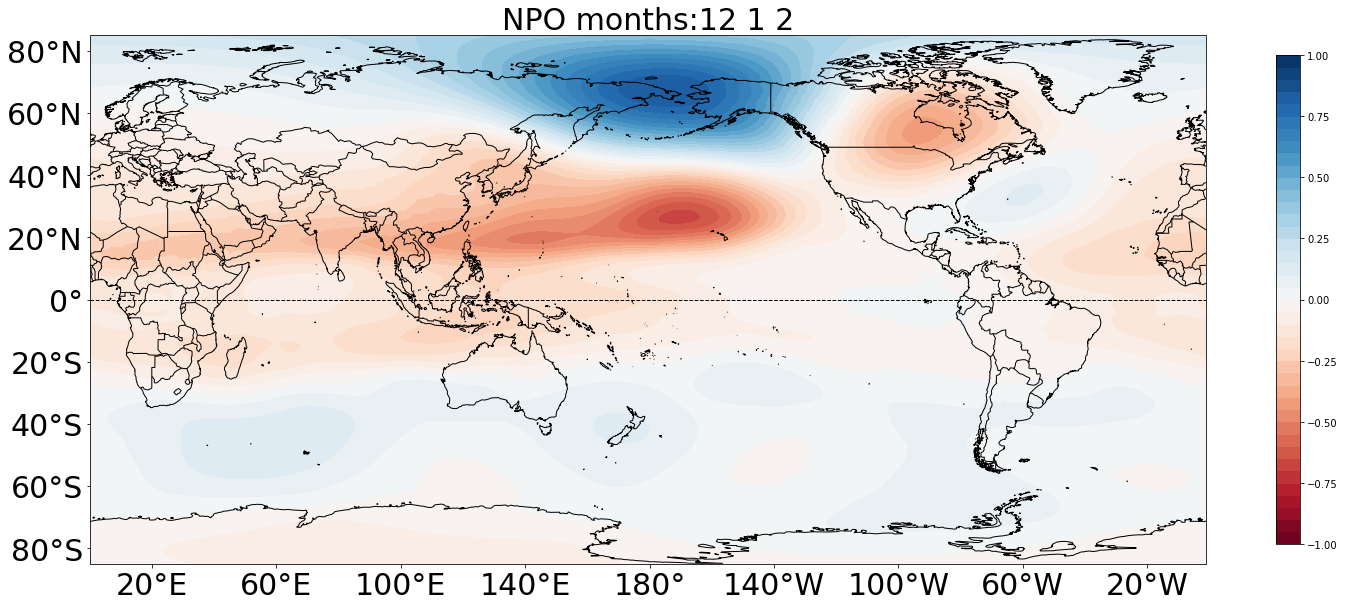

doing:  [3, 4, 5]
...Decomposing Modes...
...loading daily...
sum eof PNA: 791.0868319354688
flipping PNA [3, 4, 5]
sum eof NPO: 623.3825725215572
flipping NPO [3, 4, 5]
..loading global...
correlating


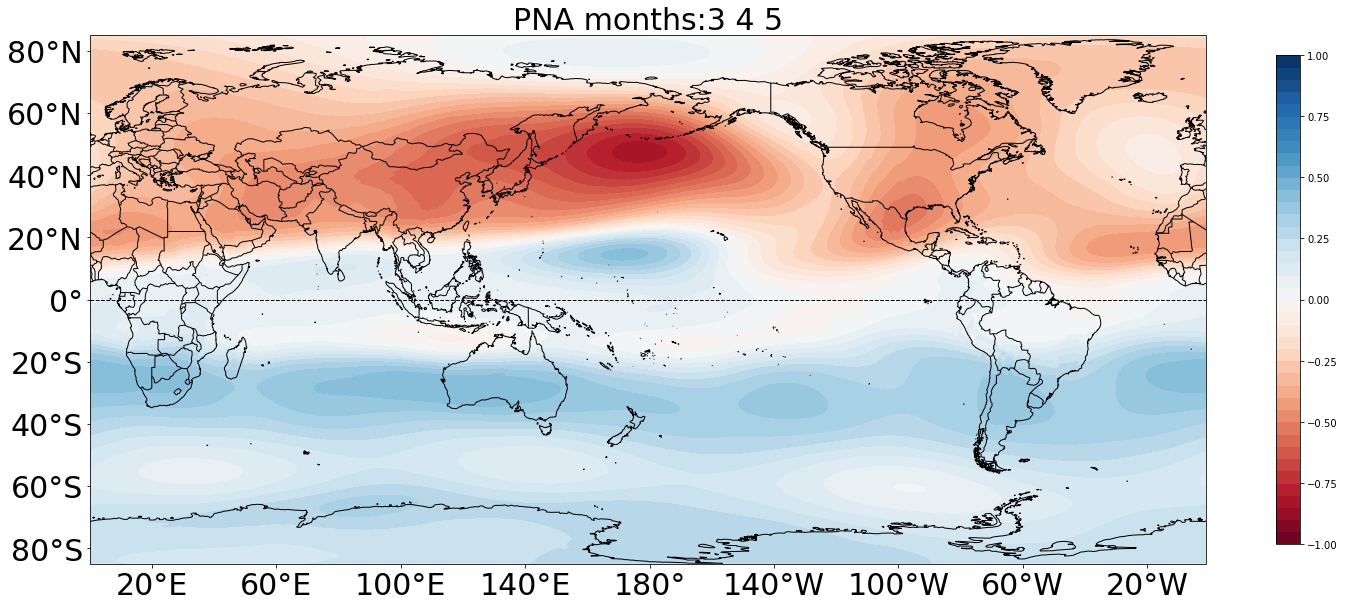

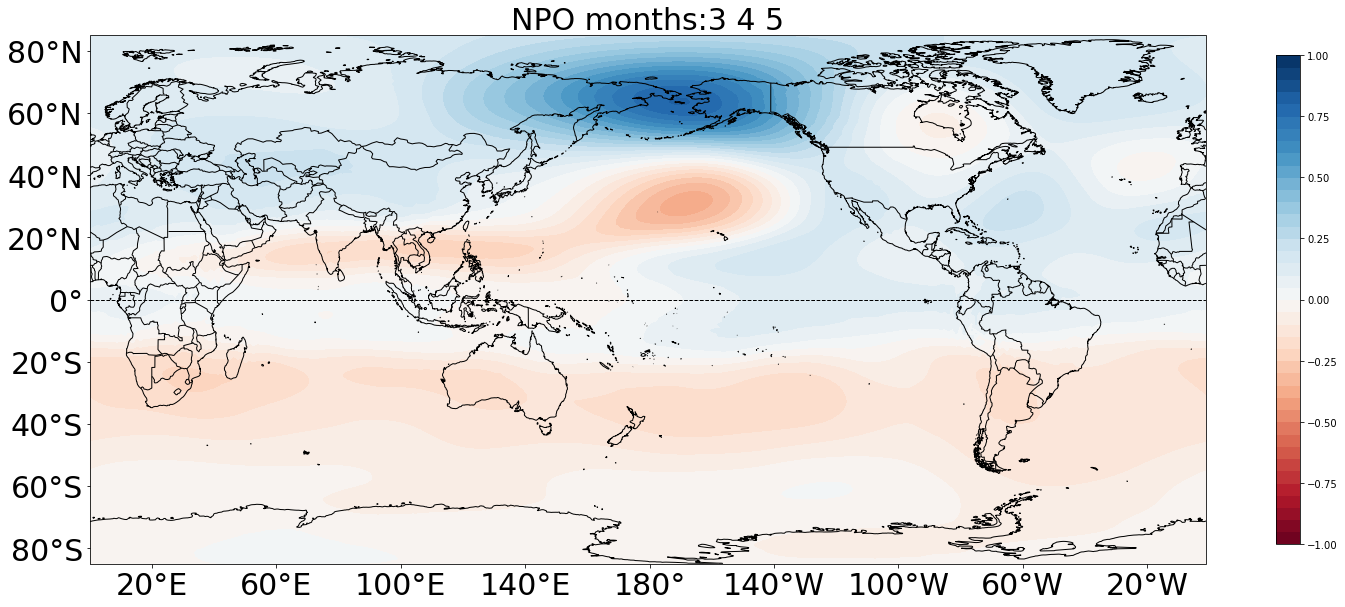

doing:  [6, 7, 8]
...Decomposing Modes...
...loading daily...
sum eof PNA: -324.707378712947
sum eof NPO: -368.31351796694804
..loading global...
correlating


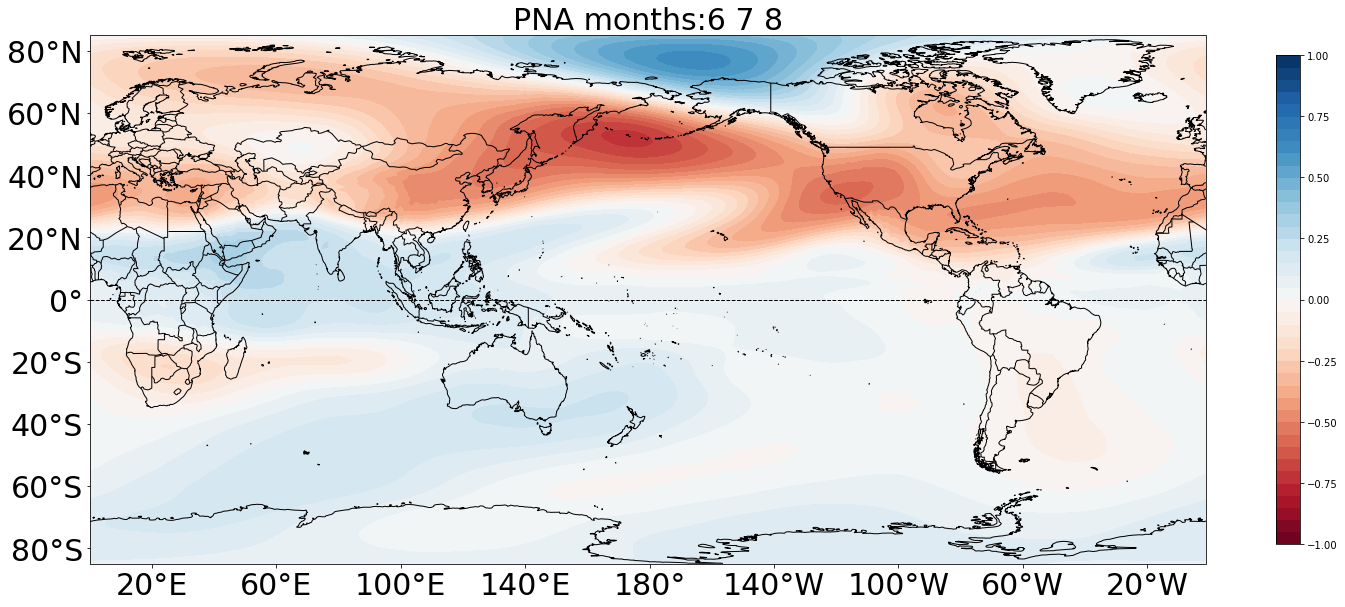

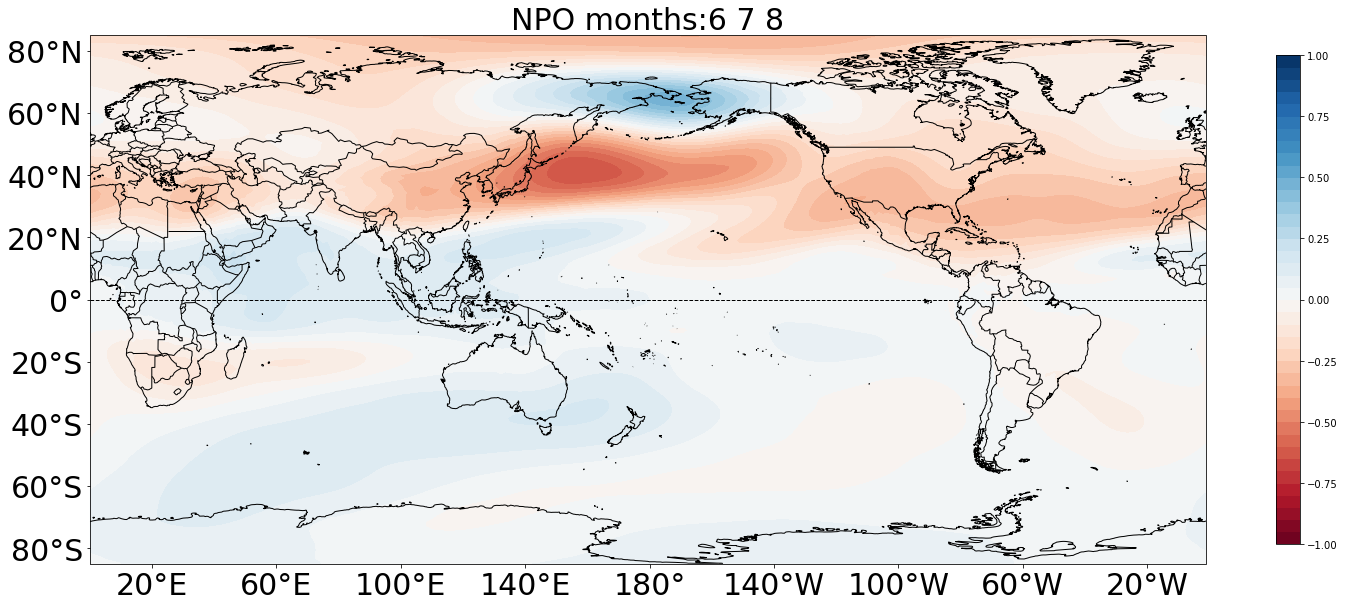

doing:  [9, 10, 11]
...Decomposing Modes...
...loading daily...
sum eof PNA: 660.3150174581056
flipping PNA [9, 10, 11]
sum eof NPO: 125.30139025869147
flipping NPO [9, 10, 11]
..loading global...
correlating


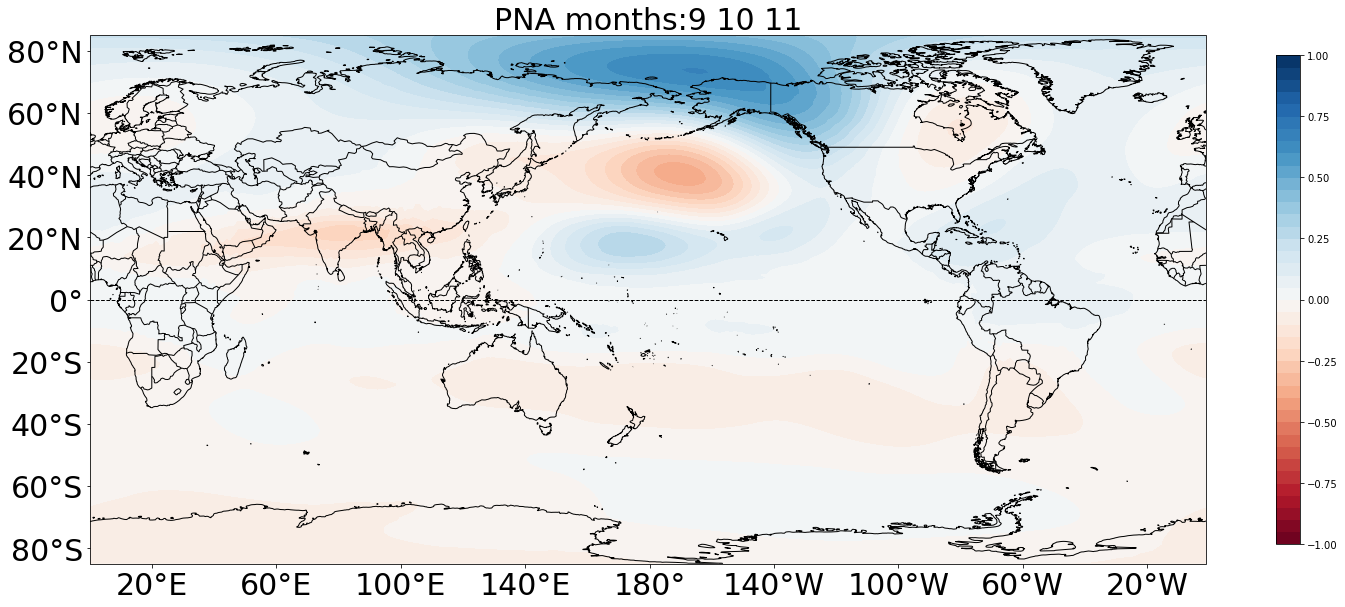

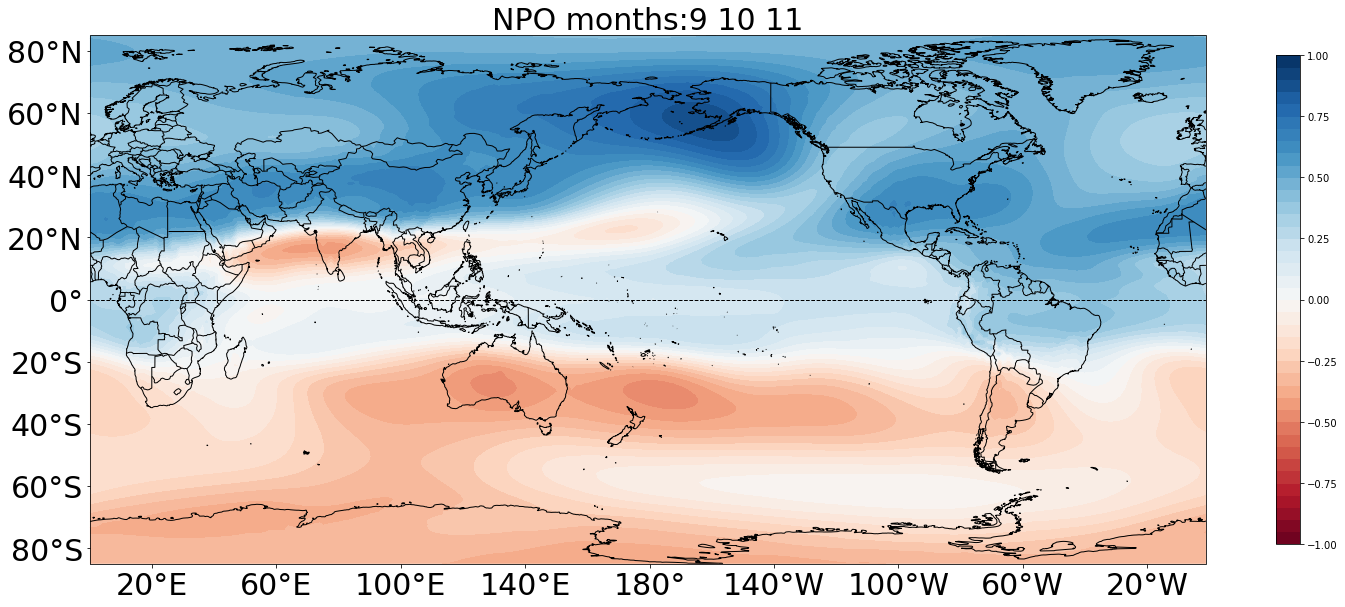

In [108]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/Z500/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))
DS = xr.open_mfdataset(files[2:4],combine='by_coords')

season_months = [[12,1,2],[3,4,5],[6,7,8],[9,10,11]]
len(season_months)
for cnt,mons in enumerate(season_months):
    print('doing: ',mons)

    seasonALL  = DS.sel(time = np.in1d(DS['time.month'], mons))
    season1=seasonALL.sel(lat=slice(20,85),lon=slice(120,240))
    Z500 = np.array(season1.groupby('time.year').mean('time')['Z500'].data)
    TEMP = Z500-np.mean(Z500)

    #set up weights 
    lats = season1['lat'].data
    lons = season1['lon'].data
    coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
    wgts = np.expand_dims(wgts,axis=0)
    ##


    print('...Decomposing Modes...')
    solver = Eof(TEMP, weights=wgts)
    eof = solver.eofsAsCorrelation(neofs=3)
    pcs = solver.pcs(npcs = 2,)    
        
    print('...loading daily...')
    dailyZ500 = np.array(season1.Z500.data)
    dailyZ500 = dailyZ500 - np.mean(dailyZ500,axis=0)
    pseudo_pcs = solver.projectField(dailyZ500, neofs=3)
    pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))

    
    #check to make sure it's the correct direction of magnitude.
    lo1 = np.argmin(np.abs(150-lons))
    lo2 = np.argmin(np.abs(210-lons))
    la1 = np.argmin(np.abs(30-lats))
    la2 = np.argmin(np.abs(55-lats))
    print('sum eof PNA:',np.sum(eof[0,la1:la2,lo1:lo2]))
    if np.sum(eof[0,la1:la2,lo1:lo2])>0:
        print('flipping PNA',mons)
        pseudo_pcs[:,0]=-1*pseudo_pcs[:,0]
        
        
    lo1 = np.argmin(np.abs(140-lons))
    lo2 = np.argmin(np.abs(220-lons))
    la1 = np.argmin(np.abs(25-lats))
    la2 = np.argmin(np.abs(50-lats))
    print('sum eof NPO:',np.sum(eof[1,la1:la2,lo1:lo2]))
    if np.sum(eof[1,la1:la2,lo1:lo2])>0:
        print('flipping NPO',mons)
        pseudo_pcs[:,1]=-1*pseudo_pcs[:,1]
    
    print('..loading global...')
    globalZ500 = np.array(seasonALL.Z500.data)
    globalZ500 = globalZ500- np.mean(globalZ500,axis=0)

    eof_corr1=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])
    eof_corr2=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])

    print('correlating')
    for lala in range(globalZ500.shape[1]):
        for lolo in range(globalZ500.shape[2]):
            eof_corr1[lala,lolo]=np.corrcoef(pseudo_pcs[:,0],globalZ500[:,lala,lolo])[0,1]
            eof_corr2[lala,lolo]=np.corrcoef(pseudo_pcs[:,1],globalZ500[:,lala,lolo])[0,1]
    
    #plotting
    mon_string = listToString(list(map(str, mons)))
    plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data,'PNA months:'+mon_string)
    plot_global_corr(eof_corr2,seasonALL['lon'].data,seasonALL['lat'].data,'NPO months:'+mon_string)
    
    
    if cnt==0:
        #turn psuedo pcs in to xarray ds 
        DS_indices = xr.Dataset(
        {
            "PNA": (["time"], pseudo_pcs[:,0].squeeze()),
            "NPO": (["time"], pseudo_pcs[:,1].squeeze())
        },
        coords={
            "time": season1.time.data,
        },
        )
    else:
        TempDS = xr.Dataset(
        {
            "PNA": (["time"], pseudo_pcs[:,0].squeeze()),
            "NPO": (["time"], pseudo_pcs[:,1].squeeze())
        },
        coords={
            "time": season1.time.data,
        },
        )
        DS_indices=xr.merge([DS_indices,TempDS])

## NAO

doing:  [12, 1, 2]
...Decomposing Modes...
...loading daily...
sum eof NAO: -1604.1299120148328
..loading global...
correlating


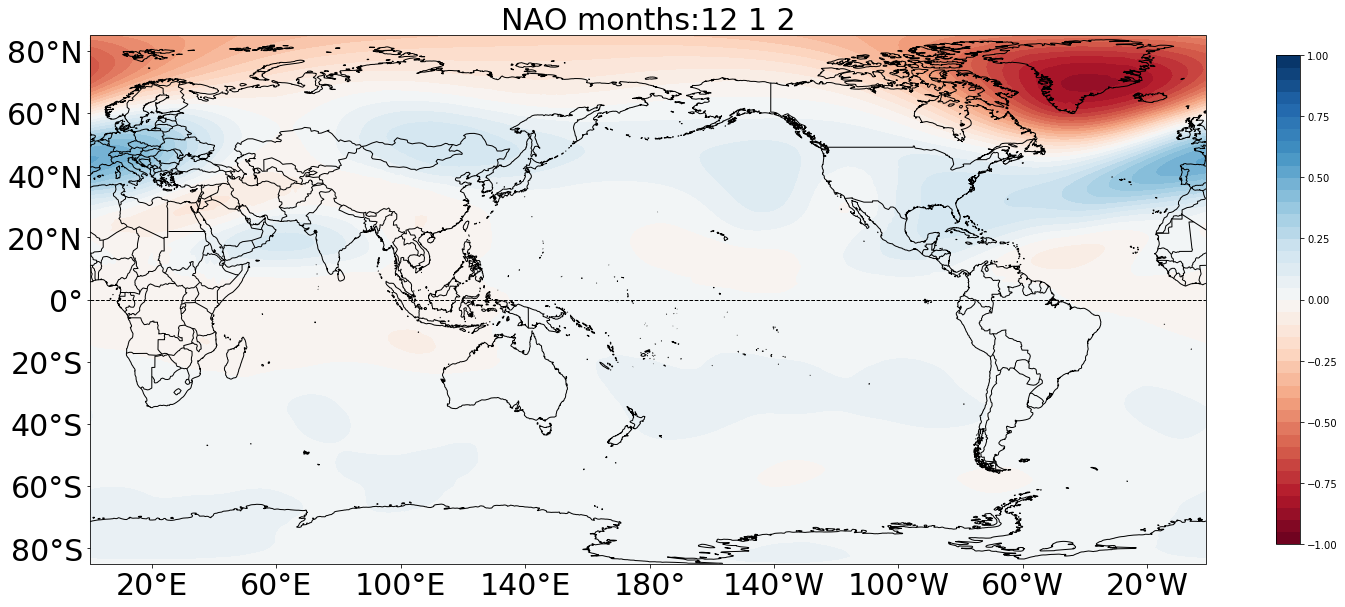

doing:  [3, 4, 5]
...Decomposing Modes...
...loading daily...
sum eof NAO: -1255.4852252894266
..loading global...
correlating


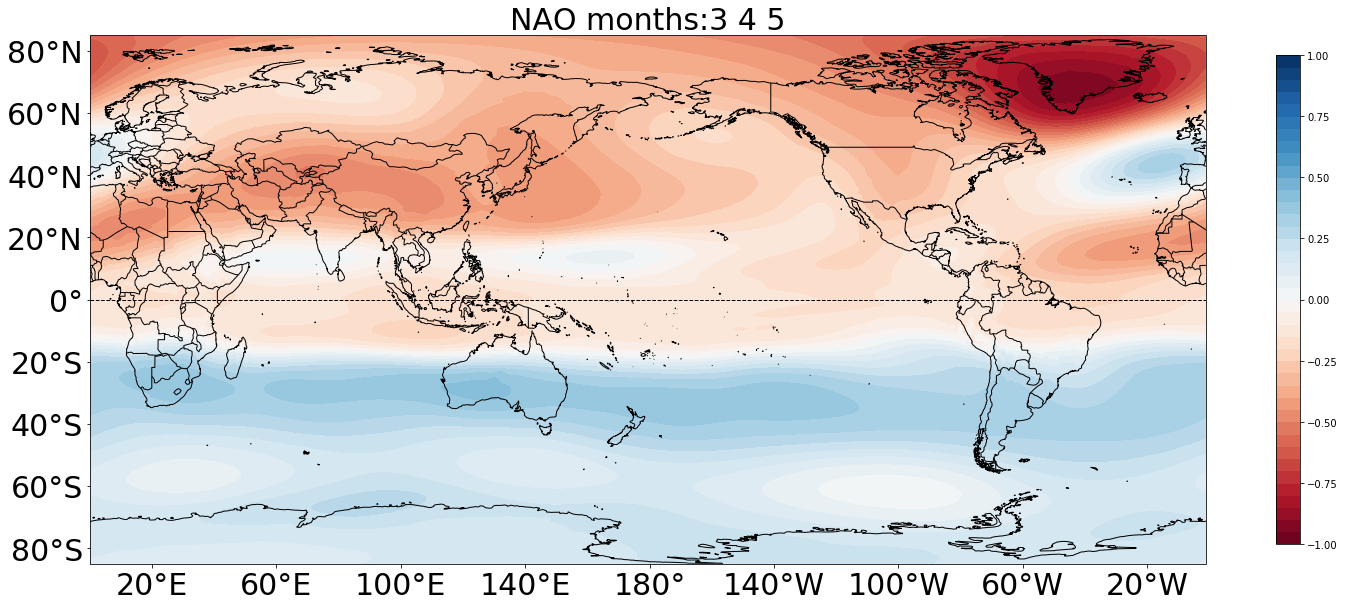

doing:  [6, 7, 8]
...Decomposing Modes...
...loading daily...
sum eof NAO: 370.73599071228847
flipping PNA [6, 7, 8]
..loading global...
correlating


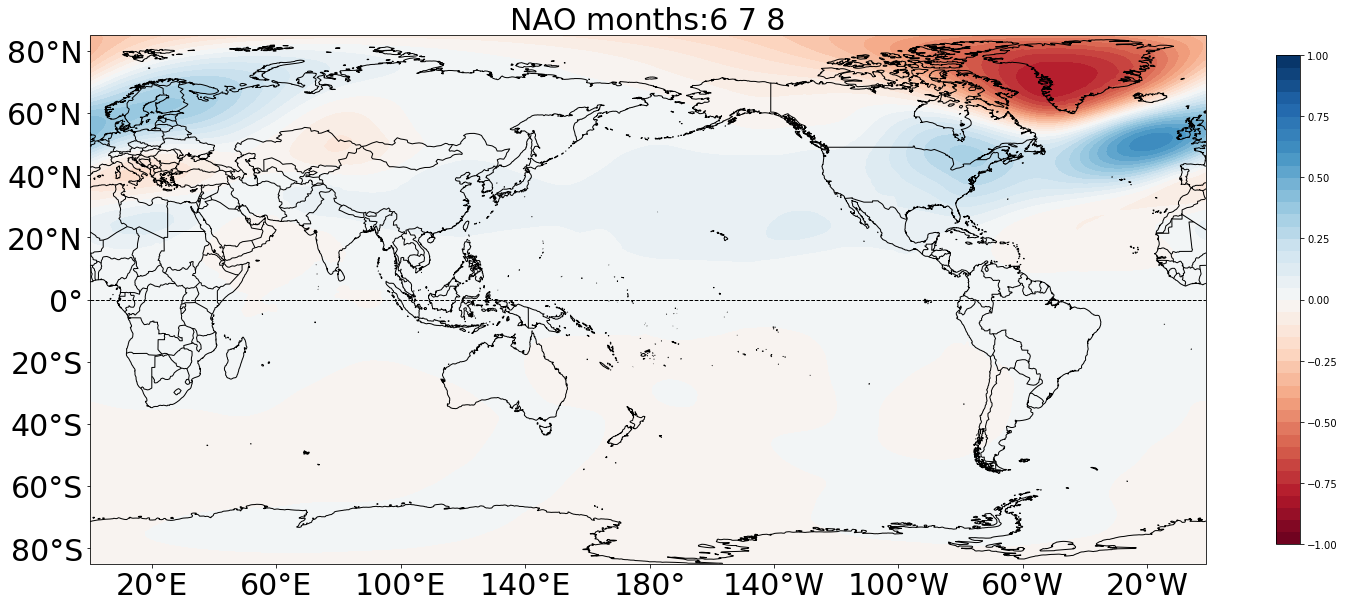

doing:  [9, 10, 11]
...Decomposing Modes...
...loading daily...
sum eof NAO: -1291.9774447360485
..loading global...
correlating


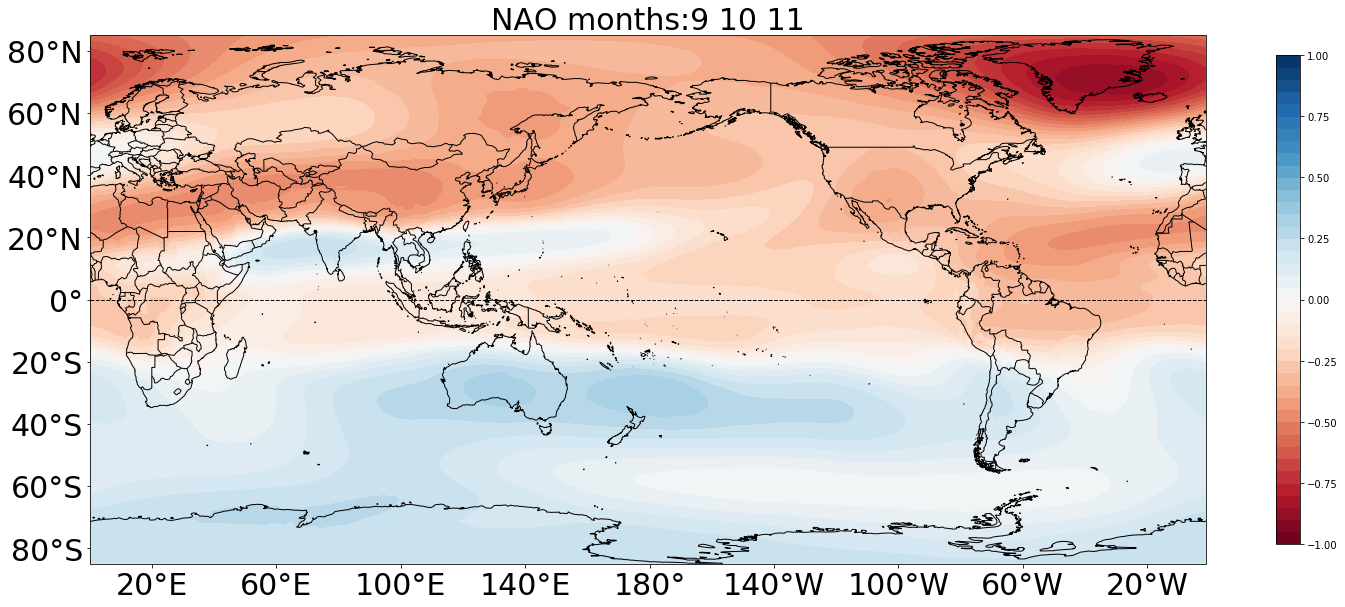

In [107]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/Z500/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))
DS = xr.open_mfdataset(files[2:5],combine='by_coords')

season_months = [[12,1,2],[3,4,5],[6,7,8],[9,10,11]]
len(season_months)
for cnt,mons in enumerate(season_months):
    print('doing: ',mons)

    seasonALL  = DS.sel(time = np.in1d(DS['time.month'], mons))
    #have to roll the dataset. 
    ds_rolled = seasonALL.assign_coords(lon=(seasonALL.lon % 360)).roll(lon=(seasonALL.dims['lon'] // 2),roll_coords=True)
    season1 = ds_rolled.sel(lat=slice(20,85),lon=slice(270,40))
    Z500 = np.array(season1.groupby('time.year').mean('time')['Z500'].data)
    TEMP = Z500-np.mean(Z500)
    
    #set up latitudinally weighting 
    lats = season1['lat'].data
    lons = season1['lon'].data
    coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
    wgts = np.expand_dims(wgts,axis=0)
    ##


    print('...Decomposing Modes...')
    solver = Eof(TEMP, weights=wgts)
    eof = solver.eofsAsCorrelation(neofs=3)
    pcs = solver.pcs(npcs = 2,)    
    
    print('...loading daily...')
    dailyZ500 = np.array(season1.Z500.data)
    dailyZ500 = dailyZ500 - np.mean(dailyZ500,axis=0)
    pseudo_pcs = solver.projectField(dailyZ500, neofs=3)
    pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))

    
    #check to make sure it's the correct direction of magnitude.

    la1 = np.argmin(np.abs(50-lats))
    la2 = np.argmin(np.abs(80-lats))
    print('sum eof NAO:',np.sum(eof[0,la1:la2,:]))
    if np.sum(eof[0,la1:la2,:])>0:
        print('flipping NAO',mons)
        pseudo_pcs[:,0]=-1*pseudo_pcs[:,0]
        
    print('..loading global...')
    globalZ500 = np.array(seasonALL.Z500.data)
    globalZ500 = globalZ500- np.mean(globalZ500,axis=0)

    eof_corr1=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])
    eof_corr2=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])

    print('correlating')
    for lala in range(globalZ500.shape[1]):
        for lolo in range(globalZ500.shape[2]):
            eof_corr1[lala,lolo]=np.corrcoef(pseudo_pcs[:,0],globalZ500[:,lala,lolo])[0,1]
    
    #plotting
    mon_string = listToString(list(map(str, mons)))
    plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data,'NAO months:'+mon_string)
    
    
    if cnt==0:
        #turn psuedo pcs in to xarray ds 
        DS_indices = xr.Dataset(
        {
            "NAO": (["time"], pseudo_pcs[:,0].squeeze()),
        },
        coords={
            "time": season1.time.data,
        },
        )
    else:
        TempDS = xr.Dataset(
        {
            "NAO": (["time"], pseudo_pcs[:,0].squeeze()),
        },
        coords={
            "time": season1.time.data,
        },
        )
        DS_indices=xr.merge([DS_indices,TempDS])

In [ ]:
def NAO_PCS(files,season_months):
    for cnt,mons in enumerate(season_months):
        print('doing: ',mons)

        seasonALL  = DS.sel(time = np.in1d(DS['time.month'], mons))
        #have to roll the dataset. 
        ds_rolled = seasonALL.assign_coords(lon=(seasonALL.lon % 360)).roll(lon=(seasonALL.dims['lon'] // 2),roll_coords=True)
        season1 = ds_rolled.sel(lat=slice(20,85),lon=slice(270,40))
        Z500 = np.array(season1.groupby('time.year').mean('time')['Z500'].data)
        TEMP = Z500-np.mean(Z500)
    
        #set up latitudinally weighting 
        lats = season1['lat'].data
        lons = season1['lon'].data
        coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
        wgts = np.sqrt(coslat)[..., np.newaxis]
        wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
        wgts = np.expand_dims(wgts,axis=0)
        ##


        print('...Decomposing Modes...')
        solver = Eof(TEMP, weights=wgts)
        eof = solver.eofsAsCorrelation(neofs=3)
        pcs = solver.pcs(npcs = 2,)    
    
        print('...loading daily...')
        dailyZ500 = np.array(season1.Z500.data)
        dailyZ500 = dailyZ500 - np.mean(dailyZ500,axis=0)
        pseudo_pcs = solver.projectField(dailyZ500, neofs=3)
        pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))

    
        #check to make sure it's the correct direction of magnitude.

        la1 = np.argmin(np.abs(50-lats))
        la2 = np.argmin(np.abs(80-lats))
        print('sum eof NAO:',np.sum(eof[0,la1:la2,:]))
        if np.sum(eof[0,la1:la2,:])>0:
            print('flipping PNA',mons)
            pseudo_pcs[:,0]=-1*pseudo_pcs[:,0]
        
        print('..loading global...')
        globalZ500 = np.array(seasonALL.Z500.data)
        globalZ500 = globalZ500- np.mean(globalZ500,axis=0)

        eof_corr1=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])
        eof_corr2=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])

        print('correlating')
        for lala in range(globalZ500.shape[1]):
            for lolo in range(globalZ500.shape[2]):
                eof_corr1[lala,lolo]=np.corrcoef(pseudo_pcs[:,0],globalZ500[:,lala,lolo])[0,1]
    
        #plotting
        mon_string = listToString(list(map(str, mons)))
        plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data,'NAO months:'+mon_string)
    
    
        if cnt==0:
            #turn psuedo pcs in to xarray ds 
            DS_indices = xr.Dataset(
            {
                "NAO": (["time"], pseudo_pcs[:,0].squeeze()),
            },
            coords={
            "time": season1.time.data,
            },
            )
        else:
            TempDS = xr.Dataset(
            {
                "NAO": (["time"], pseudo_pcs[:,0].squeeze()),
            },
            coords={
                "time": season1.time.data,
            },
            )
            DS_indices=xr.merge([DS_indices,TempDS])
    return DS_indices

...solving eof...
...loading daily...
..loading global...
correlating


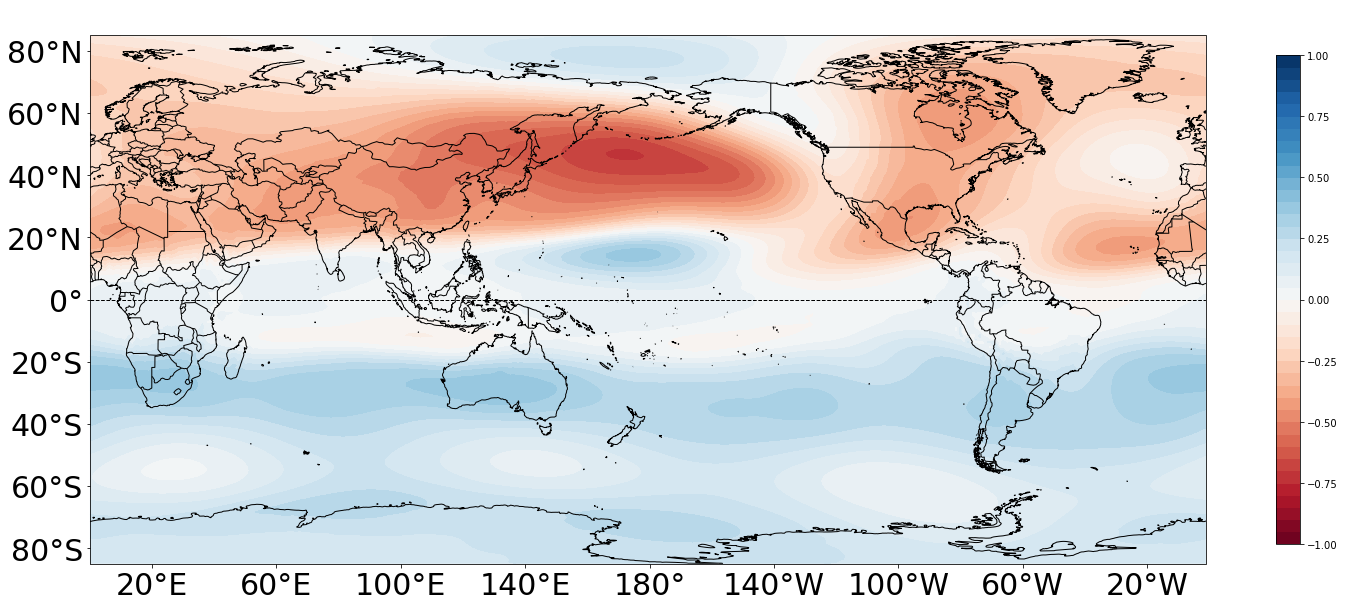

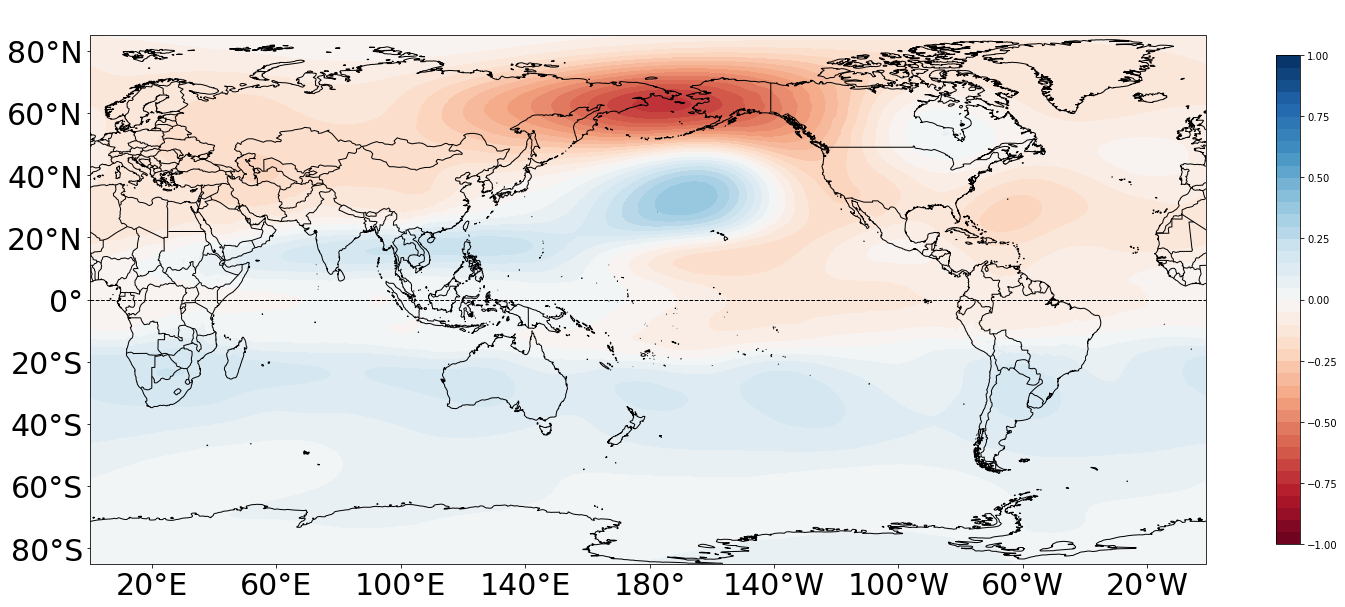

In [573]:
#this might be it
months = [6,7,8]
seasonALL  = DS.sel(time = np.in1d(DS['time.month'], months))
season1=seasonALL.sel(lat=slice(20,85),lon=slice(120,240))
Z500 = np.array(season1.groupby('time.year').mean('time')['Z500'].data)
TEMP = Z500-np.mean(Z500)

#set up weights 
lats = season1['lat'].data
lons = season1['lon'].data
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
wgts = np.expand_dims(wgts,axis=0)
##


print('...solving eof...')
solver = Eof(TEMP, weights=wgts)
eof = solver.eofsAsCorrelation(neofs=3)
pcs = solver.pcs(npcs = 2,)


print('...loading daily...')
dailyZ500 = np.array(season1.Z500.data)
dailyZ500 = dailyZ500 - np.mean(dailyZ500,axis=0)
pseudo_pcs = solver.projectField(dailyZ500, neofs=3)
pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))

print('..loading global...')
globalZ500 = np.array(seasonALL.Z500.data)
globalZ500 = globalZ500- np.mean(globalZ500,axis=0)

eof_corr1=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])
eof_corr2=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])

print('correlating')
for lala in range(globalZ500.shape[1]):
    for lolo in range(globalZ500.shape[2]):
        eof_corr1[lala,lolo]=np.corrcoef(pseudo_pcs[:,0],globalZ500[:,lala,lolo])[0,1]
        eof_corr2[lala,lolo]=np.corrcoef(pseudo_pcs[:,1],globalZ500[:,lala,lolo])[0,1]
        
plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data)
plot_global_corr(eof_corr2,seasonALL['lon'].data,seasonALL['lat'].data)

In [574]:
def plot_global_corr(field,lons,lats):
    plot_field= field.squeeze()
    lon =lons
    lat= lats

    plt.figure(figsize=(25, 20))
    proj = ccrs.PlateCarree(central_longitude=180)
    ax1 = plt.subplot(1, 1, 1, projection=proj)
    ax1.coastlines('50m')
    clevsRWS=np.arange(-1,1.05,.05) 
    haa = cm.get_cmap("Greys",len(clevsRWS))
    haa = haa(np.linspace(0,1,len(clevsRWS)))
    white=[1,1,1,1]
    haa[:3,:] = white
    #either do this 
    cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
    #or set an ocean nanmask! 
    nanmask = np.zeros_like(plot_field)+1
    plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)
    plt.plot([0-180,360-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.tick_params(labelsize=30) 
    ax1.set_extent([0,359,-85,85], crs=ccrs.PlateCarree())
    # ax1.add_feature(states_provinces, edgecolor='black')
    ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
    plt.title(' ',fontsize=30)
    plt.colorbar(shrink=0.45)
    plt.show()

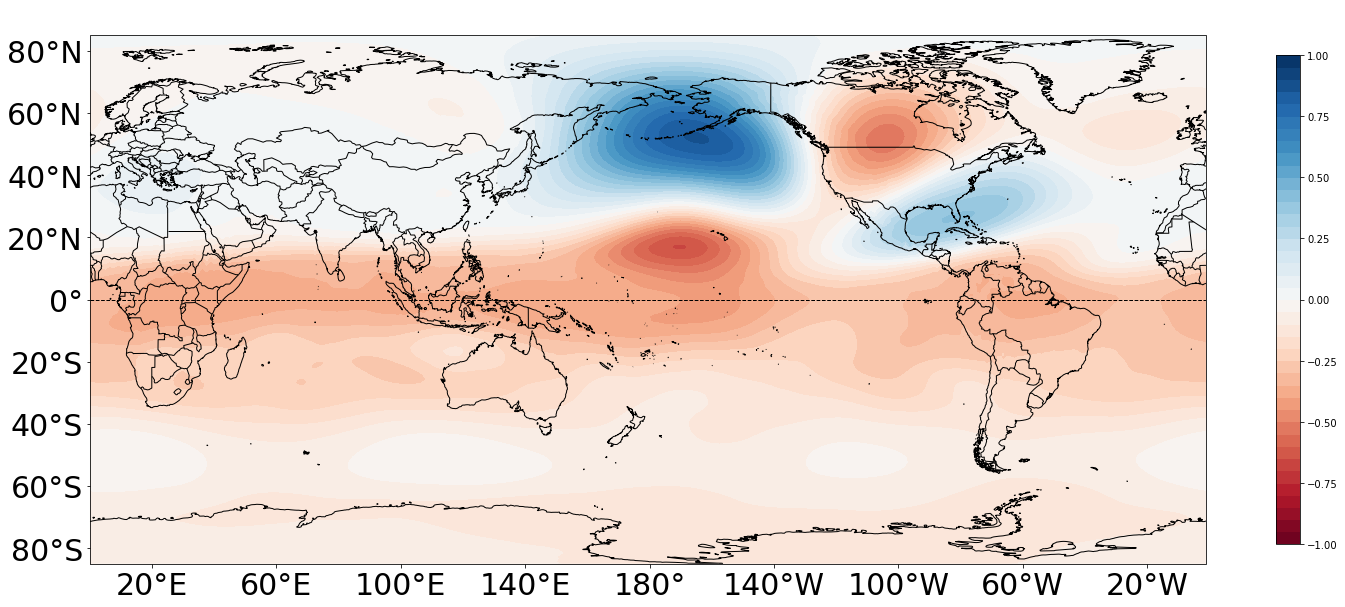

In [571]:
plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data)

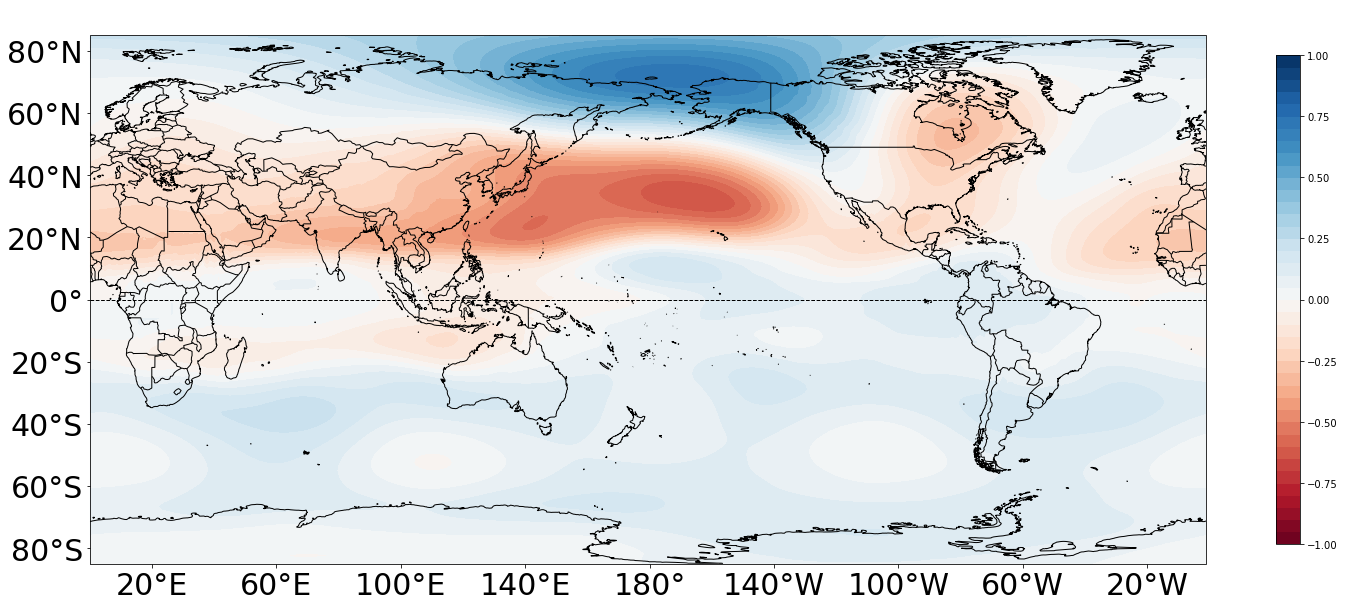

In [572]:
plot_global_corr(eof_corr2,seasonALL['lon'].data,seasonALL['lat'].data)

...starting months...
doing month 1


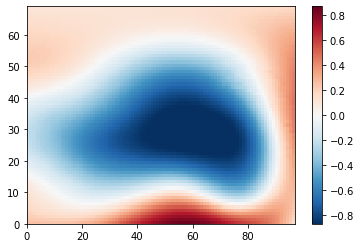

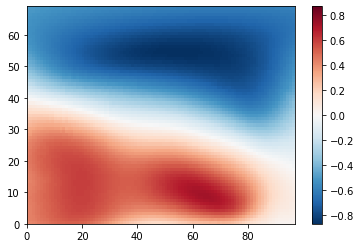

#####
doing month 2


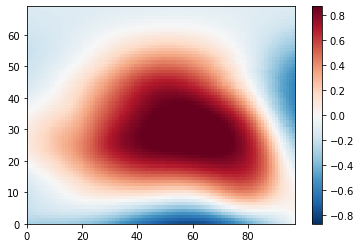

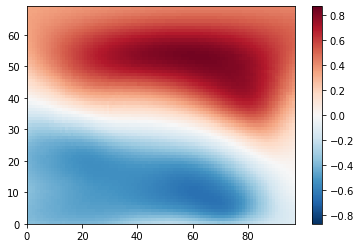

#####
doing month 3


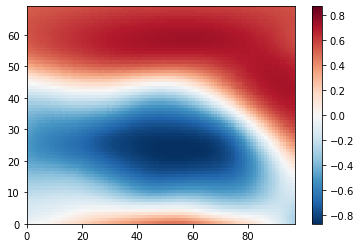

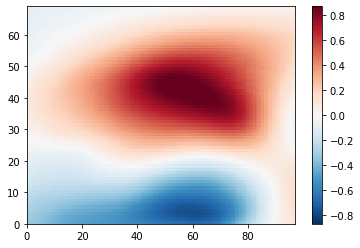

#####
doing month 4


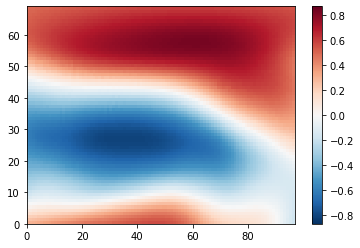

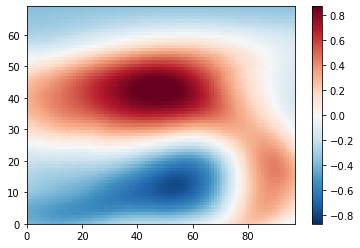

#####
doing month 5


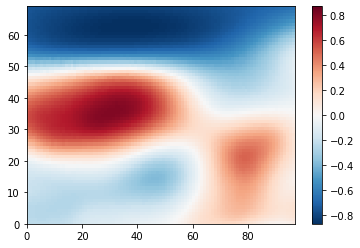

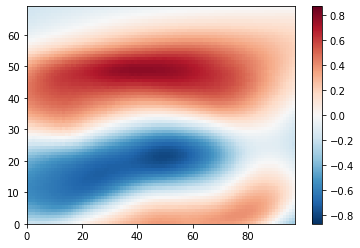

#####
doing month 6


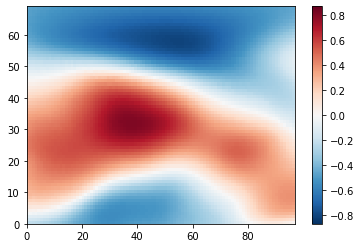

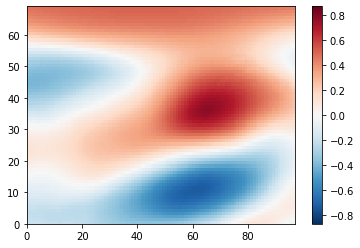

#####
doing month 7


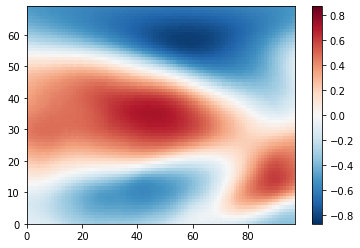

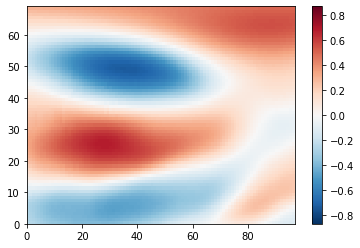

#####
doing month 8


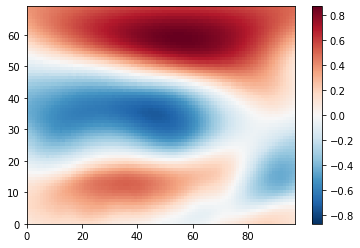

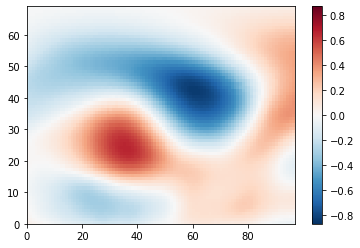

#####
doing month 9


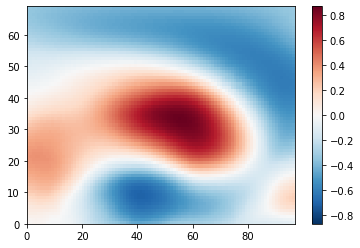

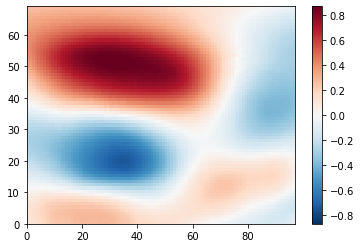

#####
doing month 10


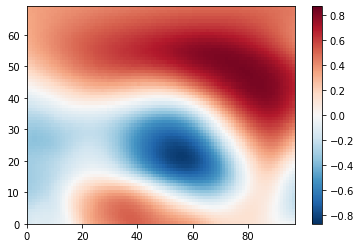

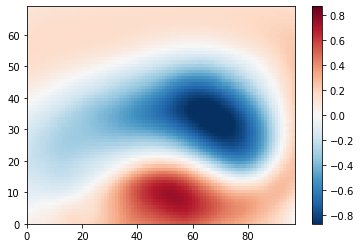

#####
doing month 11


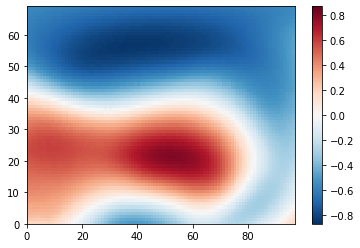

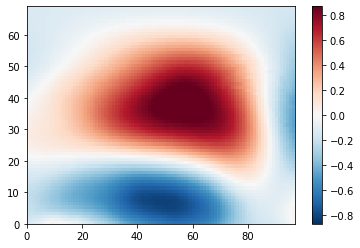

#####
doing month 12


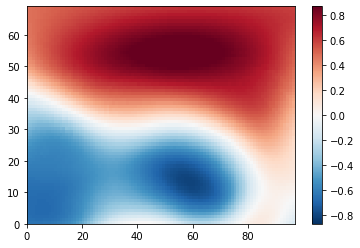

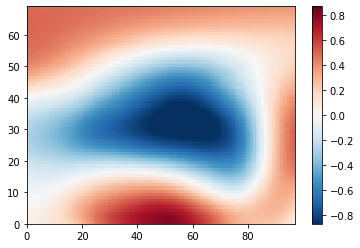

#####


In [466]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/Z500/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))

## start here ##
DS = xr.open_mfdataset(files[6:8],combine='by_coords')
DS
months =  [1,2,3,4,5,6,7,8,9,10,11,12] # for example
season1  = DS.sel(time = np.in1d(DS['time.month'], months))
season1=season1.sel(lat=slice(20,85),lon=slice(120,240))
lats = season1['lat'].data
lons = season1['lon'].data

#grab monthly means
z500 = season1['Z500'].resample(time="1MS").mean(dim="time")

#set up weights 
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]
wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
wgts = np.expand_dims(wgts,axis=0)
##

print('...starting months...')
for mo in range(1,13):
    print('doing month',mo)
    TEMP  = z500.sel(time = np.in1d(z500['time.month'], mo))
    TEMP=TEMP-np.mean(TEMP,axis=0)
    TEMP = np.array(TEMP)
    
    solver = Eof(TEMP, weights=wgts)
    eof = solver.eofsAsCorrelation(neofs=3)
    pcs = solver.pcs(npcs = 2,)
    
    plt.pcolor(eof[0,:,:],cmap='RdBu_r',vmin=-np.max(np.abs(mapss)),vmax=np.max(np.abs(mapss)))
    plt.colorbar()
    plt.show()
    plt.pcolor(eof[1,:,:],cmap='RdBu_r',vmin=-np.max(np.abs(mapss)),vmax=np.max(np.abs(mapss)))
    plt.colorbar()
    plt.show()
    print('#####')
    
    
    ##
#     Mask=np.ones([temp.shape[1],temp.shape[2]])

#     temp_flat = np.reshape(temp,[temp.shape[0],-1])
#     #get nan locations: 
#     nan_flat = np.where(np.isnan(temp_flat[0,:]))[0]
#     notnan_flat = np.where(~np.isnan(temp_flat[0,:]))[0]
#     #get 0 locations
#     zero_flat = np.where(temp_flat[0,:]==0)[0]
#     #get value locations 
#     notzero_flat = np.where(np.ndarray.flatten(Mask)==1)[0]

#     print('...forming smaller matrix...')
#     eof_temp = np.zeros([temp_flat.shape[0],notzero_flat.shape[0]])

#     for ii in range(eof_temp.shape[0]):
#         eof_temp[ii,:]=temp_flat[ii,notzero_flat]
    
#     print('...done preprocessing...')
    
#     dFIN = eof_temp #hopefully this is a time x space anomaly matrix... where time is shorter than space. 
#     print('...starting svd...')
#     A, Lh, E = np.linalg.svd(dFIN.T,full_matrices=False)
#     # Singular values are the square-root of the eigenvalues of the
#     # covariance matrix. Construct the eigenvalues appropriately and
#     # normalize by N-ddof where N is the number of observations. This
#     # corresponds to the eigenvalues of the normalized covariance matrix.
#     print('...done svd...')
#     ddof = 1 #degrees of freedom. 
#     records = dFIN.shape[0]
#     normfactor = float(records-ddof)
#     L = Lh*Lh / normfactor  #singular values
#     # Store the number of eigenvalues (and hence EOFs) that were actually computed.
#     neofs = len(L)

#     P = E.T*Lh
#     P = P/np.sqrt(L) #scaled to unit variance (e.g., divided by the square-root of their eigenvalue).
#     A = A.T
#     #variance fraction 
#     varfrac = L/L.sum()
#     total_anomaly_variance = L.sum()
#     #variance fraction 
#     plt.plot(varfrac[:10],'*')
#     plt.grid(True)
#     plt.title('variance fraction')
#     plt.show()

...Done...
Fraction of Nino years: 0.17
Fraction of Nina years: 0.14
Fraction of Neurtral years: 0.69
sum: 1.0


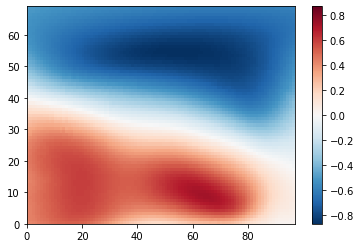

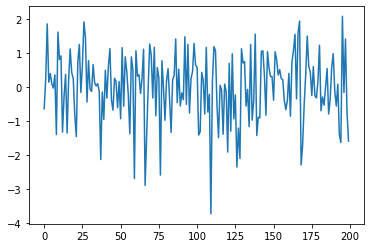

CPU times: user 792 ms, sys: 6.25 ms, total: 799 ms
Wall time: 841 ms


In [459]:
%%time
#grab the eof you want. 
eof_number = 1
Pcs = P[:,eof_number]
eofs = A[eof_number,:]/ np.sqrt(L[eof_number]) 

##reform pattern. 
mapss = np.zeros([TEMP.shape[1],TEMP.shape[2]]) 
for lala in range(TEMP.shape[1]):
    for lolo in range(TEMP.shape[2]):
        mapss[lala,lolo]=np.corrcoef(Pcs,TEMP[:,lala,lolo])[0,1]
        


#make sure pattern is positive oriented. 
if np.sum(eofs)<0:
    eofs = -1*eofs
    Pcs = -1*Pcs


print('...Done...')
print('Fraction of Nino years:',np.sum(Pcs>=1)/len(Pcs))
print('Fraction of Nina years:',np.sum(Pcs<=-1)/len(Pcs))
print('Fraction of Neurtral years:',np.sum((Pcs>=-1) &(Pcs<=1))/len(Pcs))
print('sum:',np.sum(Pcs>=1)/len(Pcs) + np.sum(Pcs<=-1)/len(Pcs) + np.sum((Pcs>=-1) &(Pcs<=1))/len(Pcs))

plt.pcolor(mapss,cmap='RdBu_r',vmin=-np.max(np.abs(mapss)),vmax=np.max(np.abs(mapss)))
plt.colorbar()
plt.show()
plt.plot(Pcs[0:200])
plt.show()


In [461]:
solver = Eof(TEMP, weights=wgts)

In [462]:
# Retrieve the leading EOF, expressed as the covariance between the leading PC
# time series and the input SLP anomalies at each grid point.
eof = solver.eofsAsCorrelation(neofs=3)
pcs = solver.pcs(npcs = 2,)

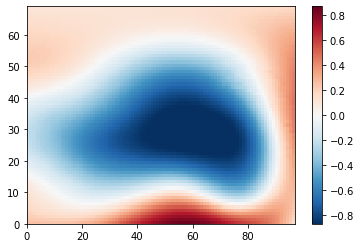

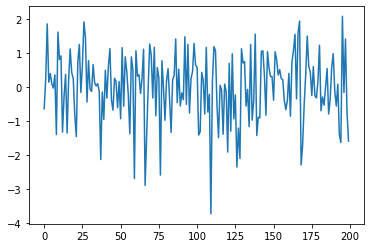

In [464]:
plt.pcolor(eof[0,:,:],cmap='RdBu_r',vmin=-np.max(np.abs(mapss)),vmax=np.max(np.abs(mapss)))
plt.colorbar()
plt.show()
plt.plot(Pcs[0:200])
plt.show()


In [448]:
temp

<xarray.DataArray 'Z500' (time: 200, lat: 59, lon: 145)>
dask.array<sub, shape=(200, 59, 145), dtype=float32, chunksize=(1, 59, 145), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1000-01-01 00:00:00 ... 1199-01-01 00:00:00
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 72.09 73.04 73.98 74.92
  * lon      (lon) float64 120.0 121.2 122.5 123.8 ... 296.2 297.5 298.8 300.0